In [32]:
import requests
import pandas as pd
from time import sleep
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from prophet import Prophet

import pandas as pd
import requests
import json
import os
from dotenv import load_dotenv
# from urllib.request import urlopen
import plotly 

# Specify the file path to save the compressed CSV
csv_file_path = 'historical_crime.csv.gz'



In [3]:
load_dotenv()

token = os.getenv("TOKEN")
# Define the base URL for the API
base_url = "https://data.cityofnewyork.us/resource/8h9b-rp9u.json"

# Define headers including the app token
headers = {
    'X-App-Token': token
}

# Function to handle pagination, fetch all data, and implement a delay between requests
def fetch_all_data(base_url, headers):
    limit = 50000  # Adjust the limit as needed, depending on what the API allows
    offset = 0
    full_data = []

    while True:
        # Construct the query with pagination and date filtering
        query_url = f"{base_url}?$limit={limit}&$offset={offset}" \
                    f"&$where=ARREST_DATE between '2014-01-01T00:00:00.000' and '2023-12-31T23:59:59.999'"
        
        response = requests.get(query_url, headers=headers)
        if response.status_code != 200:
            print(f"Failed to fetch data: HTTP Status Code {response.status_code}")
            break
        
        data = response.json()
        if not data:
            break  # Break the loop if no more data is returned
        
        full_data.extend(data)
        offset += limit
        
        # Sleep for 5 seconds before making the next request
        sleep(5)
    
    return full_data

# Fetch all data using the defined function
all_data = fetch_all_data(base_url, headers)

# Create a DataFrame from the fetched data
try:
    historical_df = pd.DataFrame(all_data)
except: 
    print("Something went wrong")

# Display the first few rows of the DataFrame to verify it
print(historical_df.head())
print(f"Total rows fetched: {len(historical_df)}")

  arrest_key              arrest_date pd_cd                          pd_desc  \
0   94273780  2014-01-01T00:00:00.000   397  ROBBERY,UNCLASSIFIED,OPEN AREAS   
1   94272165  2014-01-01T00:00:00.000   205             TRESPASS 2, CRIMINAL   
2   94273806  2014-01-01T00:00:00.000   750                 RESISTING ARREST   
3   94272052  2014-01-01T00:00:00.000   109         ASSAULT 2,1,UNCLASSIFIED   
4   94259980  2014-01-01T00:00:00.000   101                        ASSAULT 3   

  ky_cd                               ofns_desc    law_code law_cat_cd  \
0   105                                 ROBBERY  PL 1601001          F   
1   352                       CRIMINAL TRESPASS  PL 1401500          M   
2   359  OFFENSES AGAINST PUBLIC ADMINISTRATION  PL 2053000          M   
3   106                          FELONY ASSAULT  PL 1200501          F   
4   344            ASSAULT 3 & RELATED OFFENSES  PL 1200001          M   

  arrest_boro arrest_precinct jurisdiction_code age_group perp_sex  \
0   

In [4]:
# Remove unwanted columns
historical_df.dropna(axis=1)
historical_df.drop(columns=['pd_cd', 'arrest_key','law_cat_cd','law_code','pd_desc','x_coord_cd', 'y_coord_cd', 'ky_cd','arrest_precinct','jurisdiction_code' ], inplace=True)

In [5]:
# Rename Columns
new_column_names = {
    'arrest_date': 'Arrest date',
    'ofns_desc': 'Offense description',
    'arrest_boro': 'Arrest boro',
    'age_group': 'Age group',
    'perp_sex': 'Sex',
    'perp_race': 'Race',
    'latitude': 'Latitude',
    'longitude': 'Longitude'
}
historical_df.rename(columns=new_column_names,inplace=True)

In [6]:
# Write the DataFrame to a GZIP-compressed CSV file
historical_df.to_csv(csv_file_path, index=False, compression='gzip')
print(historical_df.shape[0])

2502242


In [7]:
# Read a compressed CSV file (e.g., gzip-compressed)
historical_df = pd.read_csv(csv_file_path, compression='gzip')

In [8]:
historical_df.head()

Arrest date                     Offense description  \
0  2014-01-01T00:00:00.000                                 ROBBERY   
1  2014-01-01T00:00:00.000                       CRIMINAL TRESPASS   
2  2014-01-01T00:00:00.000  OFFENSES AGAINST PUBLIC ADMINISTRATION   
3  2014-01-01T00:00:00.000                          FELONY ASSAULT   
4  2014-01-01T00:00:00.000            ASSAULT 3 & RELATED OFFENSES   

  Arrest boro Age group Sex            Race   Latitude  Longitude  \
0           B       <18   M           BLACK  40.835733 -73.921285   
1           M     25-44   M           BLACK  40.814787 -73.957502   
2           K     25-44   M           BLACK  40.575992 -73.990606   
3           B     25-44   F           WHITE  40.818079 -73.896938   
4           B     25-44   M  WHITE HISPANIC  40.837001 -73.903706   

                                             lon_lat  
0  {'type': 'Point', 'coordinates': [-73.92128542...  
1  {'type': 'Point', 'coordinates': [-73.95750196...  
2  {'type': 'Point', 'coordinates': [-73.99060607...  
3  {'type': 'Point', 'coordinates': [-73.89693760...  
4  {'type': 'Point', 'coordinates': [-73.90370600...

In [9]:
# Converting the list of data into a DataFrame
##historical_df = pd.DataFrame(all_data)
#historical_df

In [51]:
historical_df.dtypes

Arrest date            datetime64[ns]
Offense description            object
Arrest boro                    object
Age group                      object
Sex                            object
Race                           object
Latitude                      float64
Longitude                     float64
lon_lat                        object
year                            int32
dtype: object

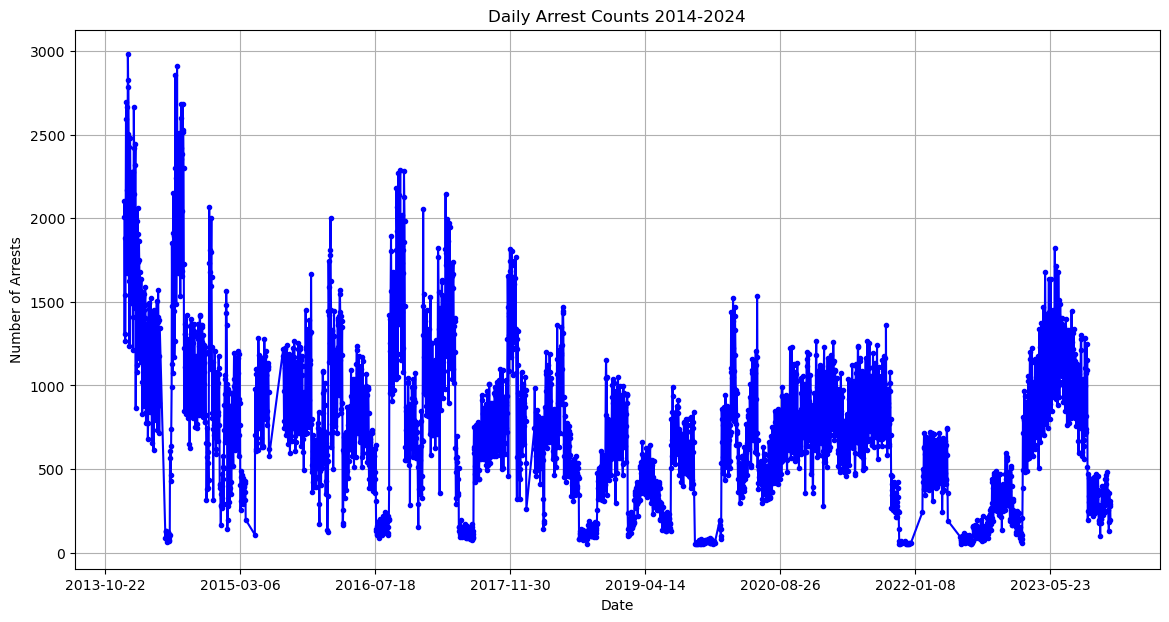

In [34]:
historical_df['Arrest date'] = pd.to_datetime(historical_df['Arrest date']).dt.date
arrest_counts = historical_df.groupby('Arrest date').size()

arrest_counts = arrest_counts[arrest_counts >= 50]

plt.figure(figsize=(14, 7))  
arrest_counts.plot(kind='line', color='blue', marker='.', linestyle='-')  

plt.title('Daily Arrest Counts 2014-2024')  # 
plt.xlabel('Date')  
plt.ylabel('Number of Arrests')  
plt.grid(True)  

# Improve the x-axis ticks to show fewer dates for clarity
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Adjust the number as needed

plt.show()

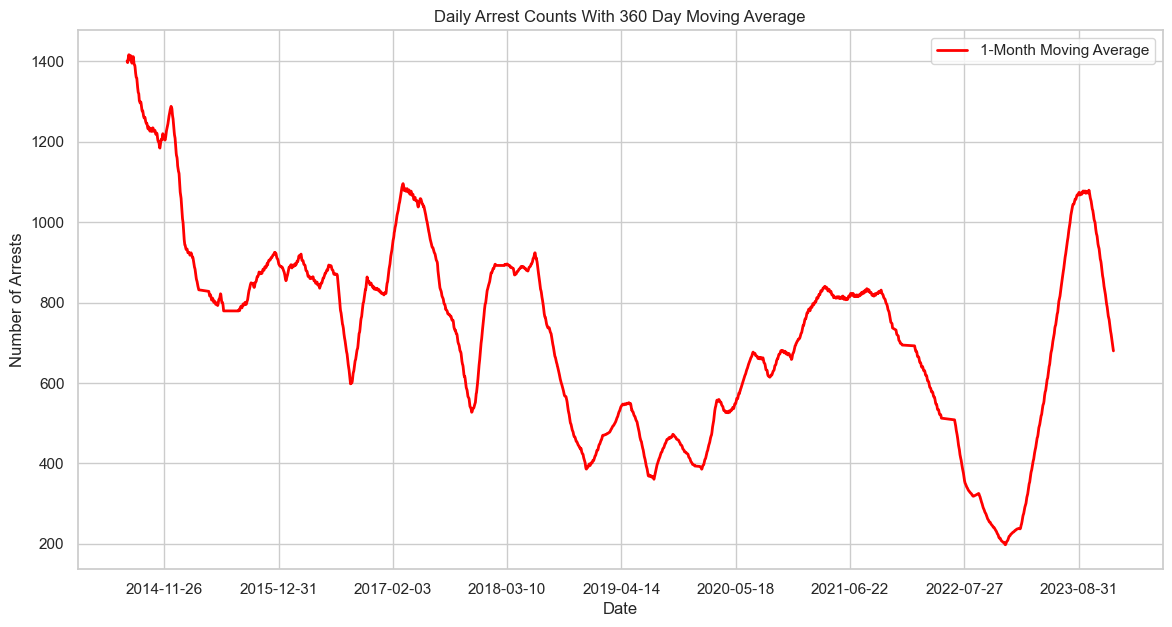

In [95]:
# Calculate the 30-day moving average of arrest counts
moving_average = arrest_counts.rolling(window=180
                                      ).mean()

# Plot the moving average on top of the existing daily arrests plot
plt.figure(figsize=(14, 7))
#arrest_counts.plot(kind='line', color='blue', marker='.', linestyle='-')  # Your existing daily plot
moving_average.plot(kind='line', color='red', linewidth=2, label='1-Month Moving Average')  # Moving average

plt.title('Daily Arrest Counts With 180 Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Number of Arrests')
plt.legend()
plt.grid(True)

# Set major x-axis locator for clarity if there are many data points
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))

plt.show()

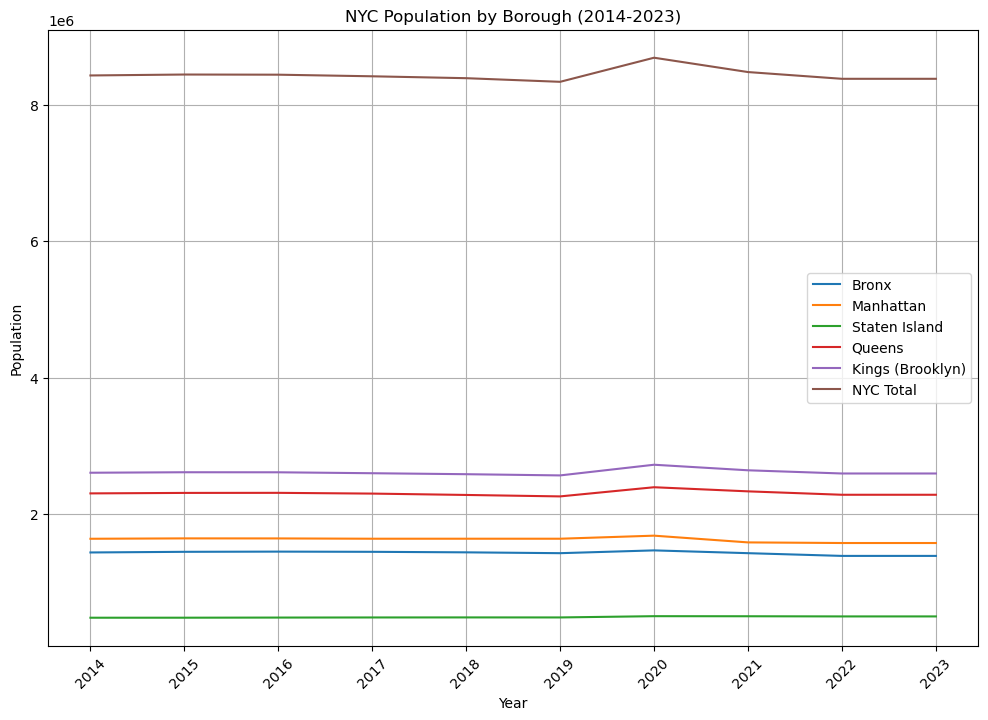

In [41]:
data = {
    "Year": ["2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023"],
    "Bronx": [1430500, 1440000, 1443000, 1440000, 1432300, 1420000, 1461000, 1420100, 1380000, 1380000],
    "Manhattan": [1631700, 1637300, 1636700, 1632300, 1632400, 1632300, 1677300, 1578300, 1569300, 1569300],
    "Staten Island": [472000, 472300, 474200, 475800, 476500, 476100, 494600, 493500, 491100, 491100],
    "Queens": [2298234, 2305252, 2306249, 2295226, 2275286, 2253942, 2388586, 2328141, 2278029, 2278029],
    "Kings (Brooklyn)": [2601527, 2608797, 2608146, 2594357, 2580088, 2562329, 2719044, 2637486, 2590516, 2590516],
    "NYC Total": [8436961, 8450649, 8448295, 8424683, 8396874, 8343671, 8697530, 8486927, 8387845, 8387845]
}
# Convert the dictionary to a DataFrame
df_nyc_population = pd.DataFrame(data)


# Plot the data
plt.figure(figsize=(12, 8))
for column in df_nyc_population.columns[1:]:
    plt.plot(df_nyc_population["Year"], df_nyc_population[column], label=column)

# Add title and labels
plt.title('NYC Population by Borough (2014-2023)')
plt.xlabel('Year')
plt.ylabel('Population')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


In [58]:
# Group by year and borough to count the number of arrests each year
annual_arrest_counts = historical_df.groupby(['year', 'Arrest boro']).size().unstack(fill_value=0)

# Add a column for NYC Total
annual_arrest_counts['NYC Total'] = annual_arrest_counts.sum(axis=1)

# Reset the index to have 'Year' as a column
annual_arrest_counts.reset_index(inplace=True)

# Rename the columns to be more descriptive
annual_arrest_counts.columns.name = None
annual_arrest_counts.rename(columns={'year': 'Year', 'B': 'Bronx', 'M': 'Manhattan', 'S': 'Staten Island', 'Q': 'Queens', 'K': 'Brooklyn'}, inplace=True)

# Display the DataFrame
print(annual_arrest_counts)

   Year  Bronx  Brooklyn  Manhattan  Queens  Staten Island  NYC Total
0  2014  97821    121446     120998   86661          15031     441957
1  2015  53056     63836      65260   45697           7817     235666
2  2016  68405     86659      84624   59783          12307     311778
3  2017  69375     88405      84386   61859          12404     316429
4  2018  43241     53697      49231   39267           8177     193613
5  2019  32242     38369      35336   29207           5951     141105
6  2020  57535     67125      57865   52830          10887     246242
7  2021  54376     66778      62720   52845          11621     248340
8  2022  22071     23231      23482   18190           3277      90251
9  2023  64613     76599      63888   59340          12421     276861


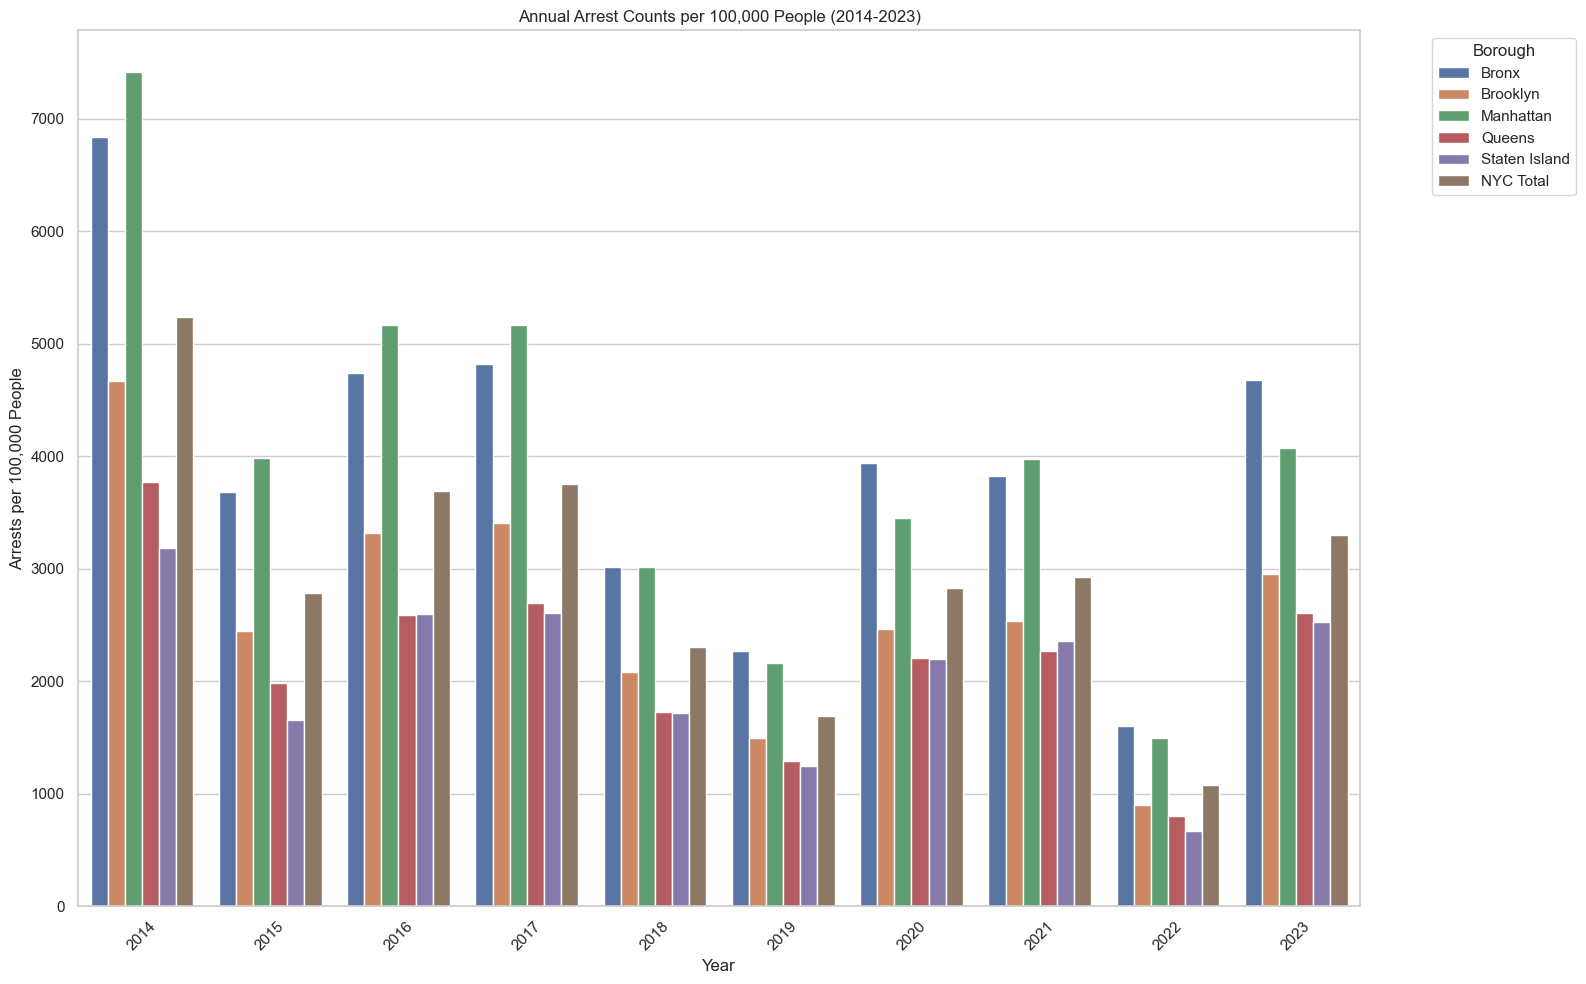

In [71]:
data = {
    "Year": [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
    "Bronx": [6838.24, 3684.44, 4740.47, 4817.71, 3018.99, 2270.56, 3938.06, 3829.03, 1599.35, 4682.10],
    "Brooklyn": [4668.26, 2446.95, 3322.63, 3407.59, 2081.21, 1497.43, 2468.70, 2531.88, 896.77, 2956.90],
    "Manhattan": [7415.46, 3985.83, 5170.40, 5169.76, 3015.87, 2164.80, 3449.89, 3973.90, 1496.34, 4071.11],
    "Queens": [3770.76, 1982.30, 2592.22, 2695.12, 1725.81, 1295.82, 2211.77, 2269.84, 798.50, 2604.88],
    "Staten Island": [3184.53, 1655.09, 2595.32, 2606.98, 1716.05, 1249.95, 2201.17, 2354.81, 667.28, 2529.22],
    "NYC Total": [5238.34, 2788.73, 3690.43, 3755.98, 2305.77, 1691.16, 2831.17, 2926.15, 1075.97, 3300.74]
}

# Create DataFrame
df_arrests_per_100k = pd.DataFrame(data)

# Melt the DataFrame to long format
df_arrests_per_100k_melted = df_arrests_per_100k.melt(id_vars='Year', var_name='Borough', value_name='Arrests per 100,000 People')

# Set the style
sns.set(style="whitegrid")

# Create the barplot
plt.figure(figsize=(16, 10))
sns.barplot(x='Year', y='Arrests per 100,000 People', hue='Borough', data=df_arrests_per_100k_melted)

# Set the labels and title
plt.title('Annual Arrest Counts per 100,000 People (2014-2023)')
plt.xlabel('Year')
plt.ylabel('Arrests per 100,000 People')
plt.xticks(rotation=45)
plt.legend(title='Borough', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

In [15]:
historical_df['Offense description'].value_counts()

Offense description
DANGEROUS DRUGS                           335389
ASSAULT 3 & RELATED OFFENSES              327160
PETIT LARCENY                             212872
FELONY ASSAULT                            157669
VEHICLE AND TRAFFIC LAWS                  146681
                                           ...  
ABORTION                                       7
NYS LAWS-UNCLASSIFIED VIOLATION                3
UNDER THE INFLUENCE, DRUGS                     2
UNLAWFUL POSS. WEAP. ON SCHOOL GROUNDS         2
KIDNAPPING AND RELATED OFFENSES                1
Name: count, Length: 85, dtype: int64

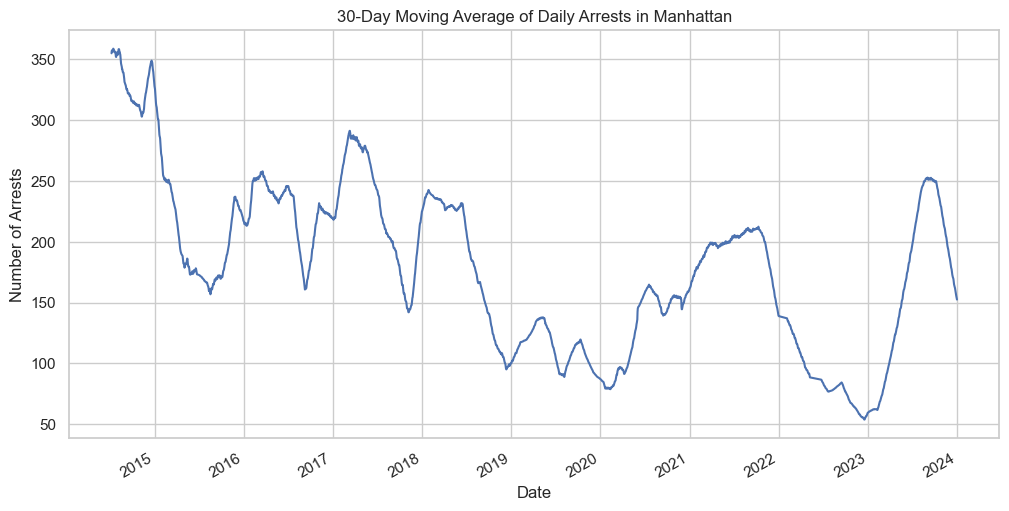

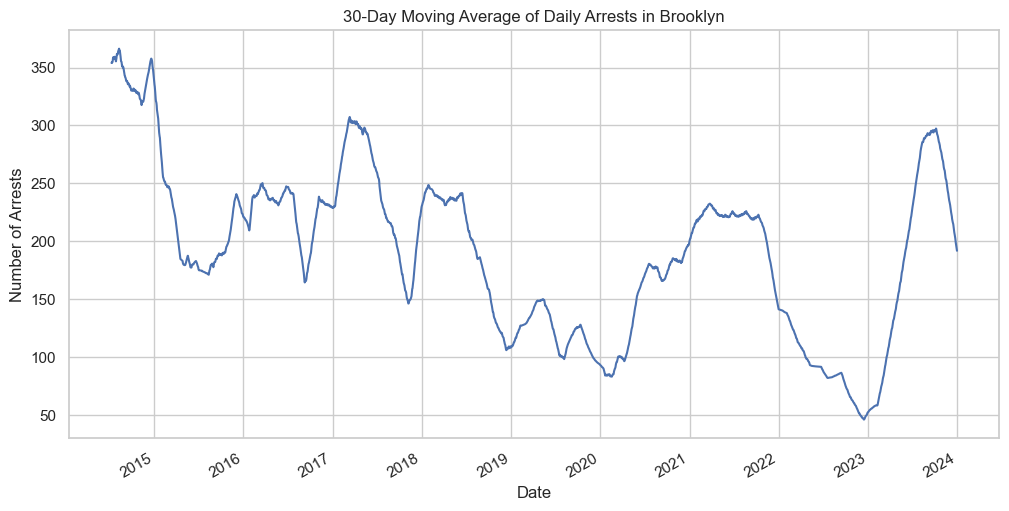

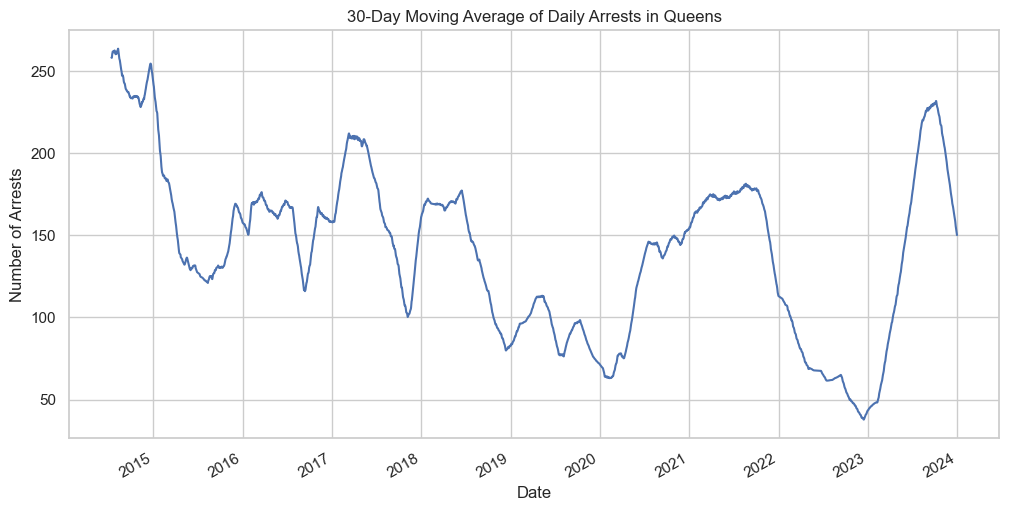

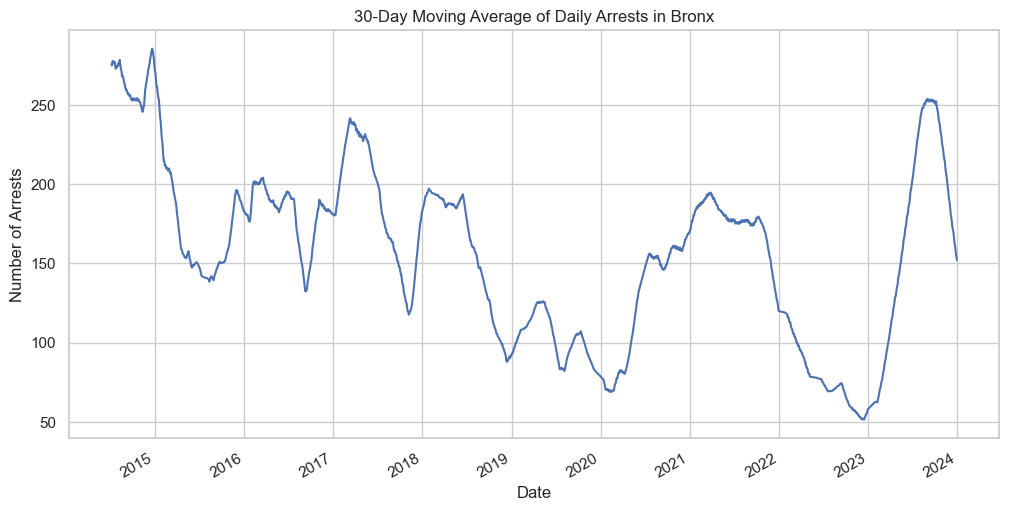

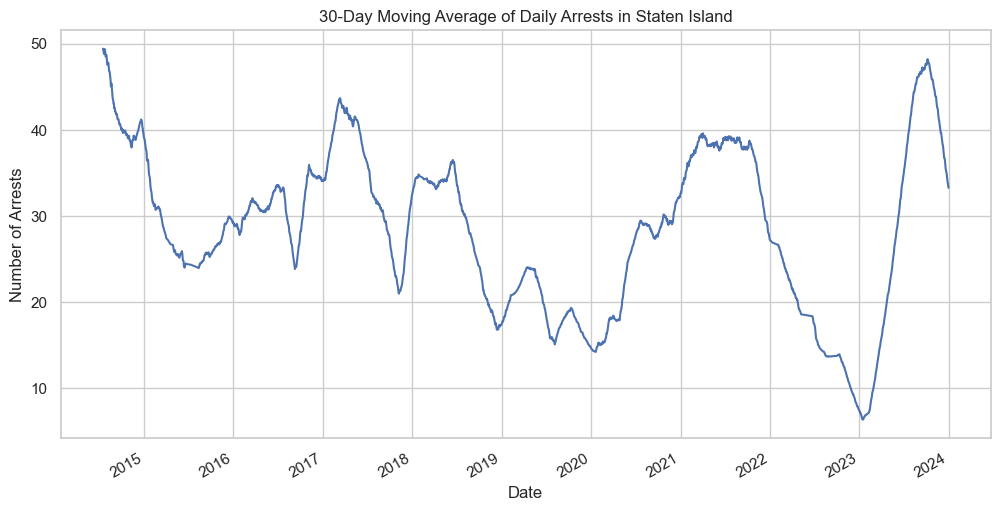

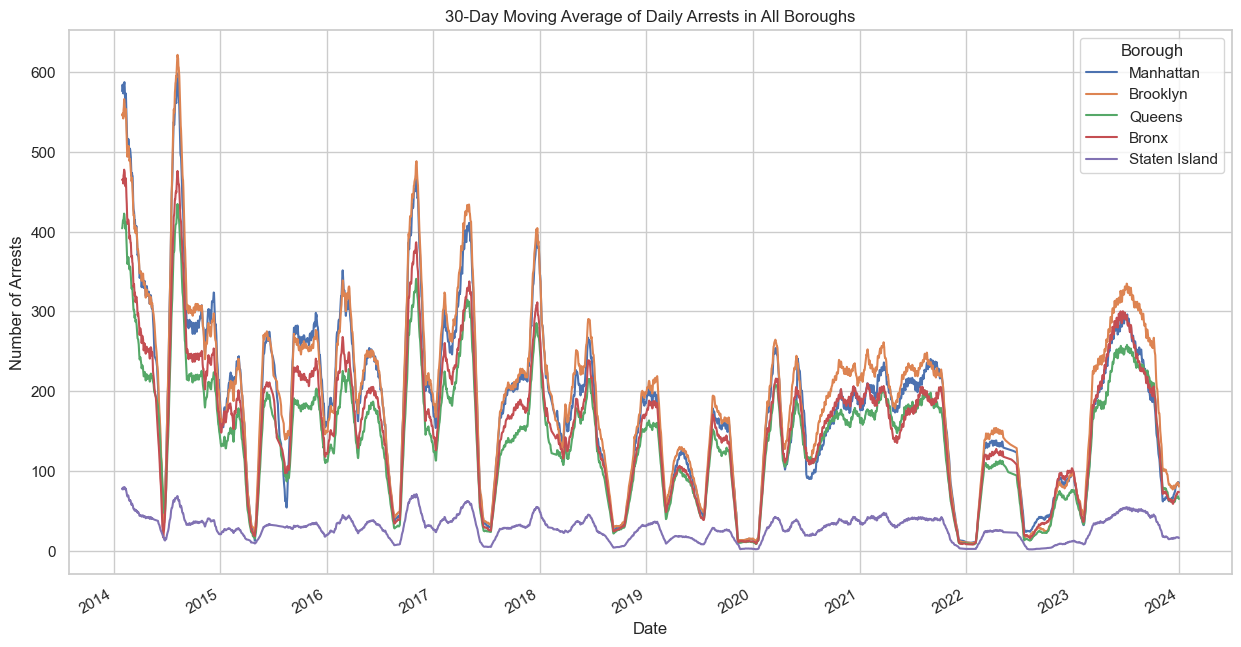

In [77]:
# Define borough keys and labels for reference
borough_labels = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']
borough_keys = ['M', 'K', 'Q', 'B', 'S']

# Plotting the data for each borough separately with a 30-day moving average
for boro_key, boro_label in zip(borough_keys, borough_labels):
    # Filter data for the current borough
    borough_data = historical_df[historical_df['Arrest boro'] == boro_key]
    
    # Group by arrest_date and count the occurrences
    daily_counts = borough_data.groupby('Arrest date').size()
    
    # Calculate 30-day moving average
    moving_average = daily_counts.rolling(window=180).mean()
    
    # Plotting
    plt.figure(figsize=(12, 6))
    moving_average.plot(title=f'30-Day Moving Average of Daily Arrests in {boro_label}')
    plt.xlabel('Date')
    plt.ylabel('Number of Arrests')
    plt.grid(True)
    plt.show()

# Combined plot for all boroughs with a 30-day moving average
plt.figure(figsize=(15, 8))
for boro_key, boro_label in zip(borough_keys, borough_labels):
    # Filter data for the current borough
    borough_data = historical_df[historical_df['Arrest boro'] == boro_key]
    
    # Group by arrest_date and count the occurrences
    daily_counts = borough_data.groupby('Arrest date').size()
    
    # Calculate 30-day moving average
    moving_average = daily_counts.rolling(window=30).mean()
    
    # Plotting
    moving_average.plot(kind='line', label=boro_label)

plt.title('30-Day Moving Average of Daily Arrests in All Boroughs')
plt.xlabel('Date')
plt.ylabel('Number of Arrests')
plt.legend(title='Borough')
plt.grid(True)
plt.show()

In [17]:
print(historical_df.columns)

Index(['Arrest date', 'Offense description', 'Arrest boro', 'Age group', 'Sex',
       'Race', 'Latitude', 'Longitude', 'lon_lat', 'year'],
      dtype='object')


In [18]:
# Step 1: Group by 'boro' and 'crime_type' and count occurrences
crime_counts = historical_df.groupby(['Arrest boro', 'Offense description']).size().reset_index(name='count')

sorted_crimes = crime_counts.sort_values(by=['Arrest boro', 'count'], ascending=[True, False])

most_common_crimes = sorted_crimes.groupby('Arrest boro').head()

print(most_common_crimes)


    Arrest boro              Offense description  count
7             B     ASSAULT 3 & RELATED OFFENSES  92143
16            B                  DANGEROUS DRUGS  90922
23            B                   FELONY ASSAULT  41854
65            B                    PETIT LARCENY  38705
76            B         VEHICLE AND TRAFFIC LAWS  33744
94            K                  DANGEROUS DRUGS  90339
85            K     ASSAULT 3 & RELATED OFFENSES  87439
102           K                   FELONY ASSAULT  47241
146           K                    PETIT LARCENY  46467
125           K          MISCELLANEOUS PENAL LAW  44799
175           M                  DANGEROUS DRUGS  88789
228           M                    PETIT LARCENY  81238
166           M     ASSAULT 3 & RELATED OFFENSES  62093
222           M  OTHER OFFENSES RELATED TO THEFT  42853
189           M                    GRAND LARCENY  40006
250           Q     ASSAULT 3 & RELATED OFFENSES  72964
259           Q                  DANGEROUS DRUGS

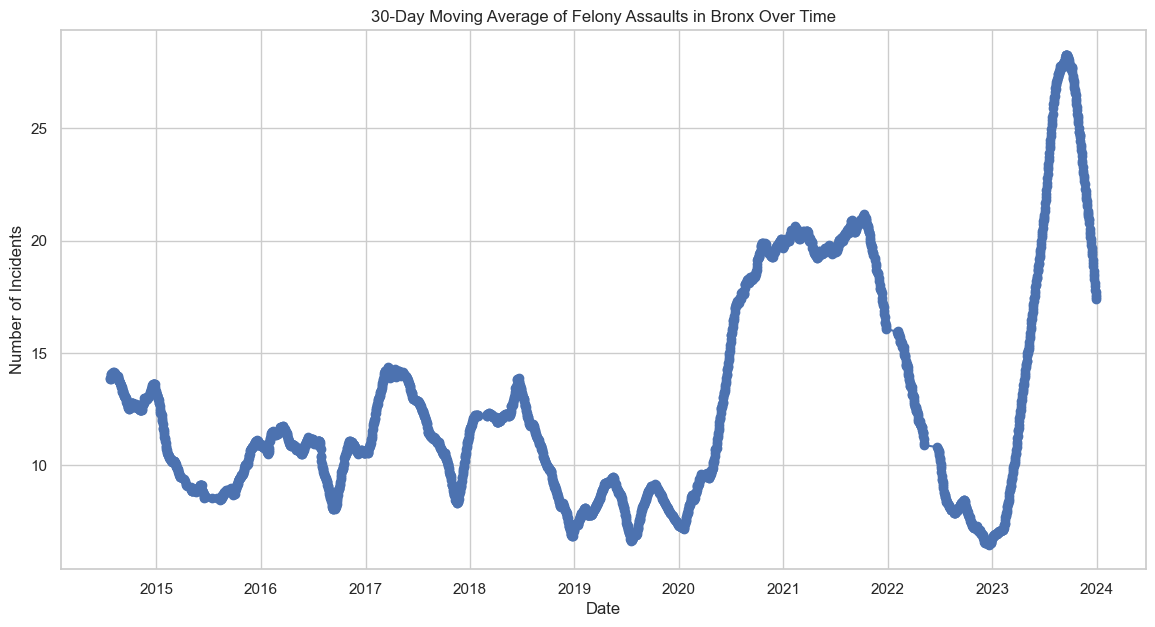

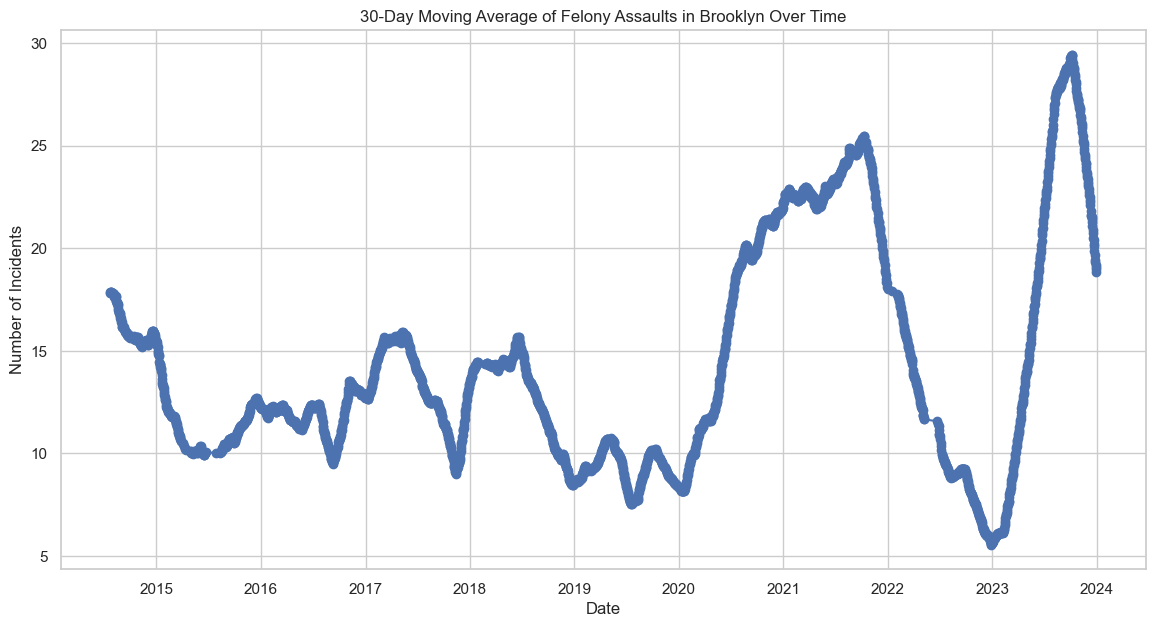

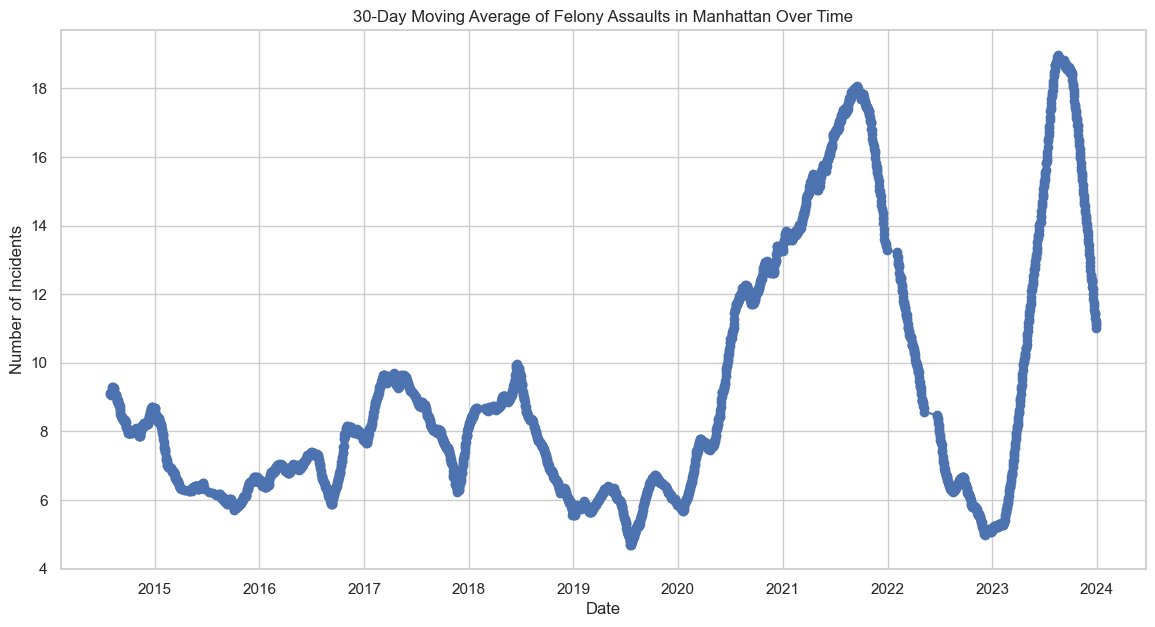

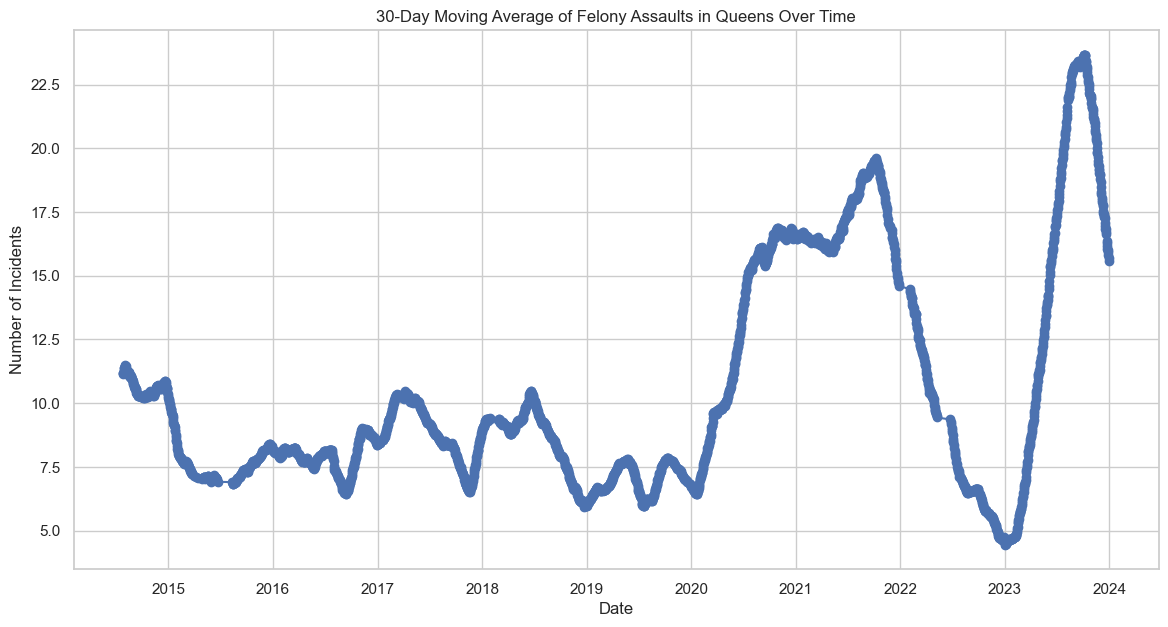

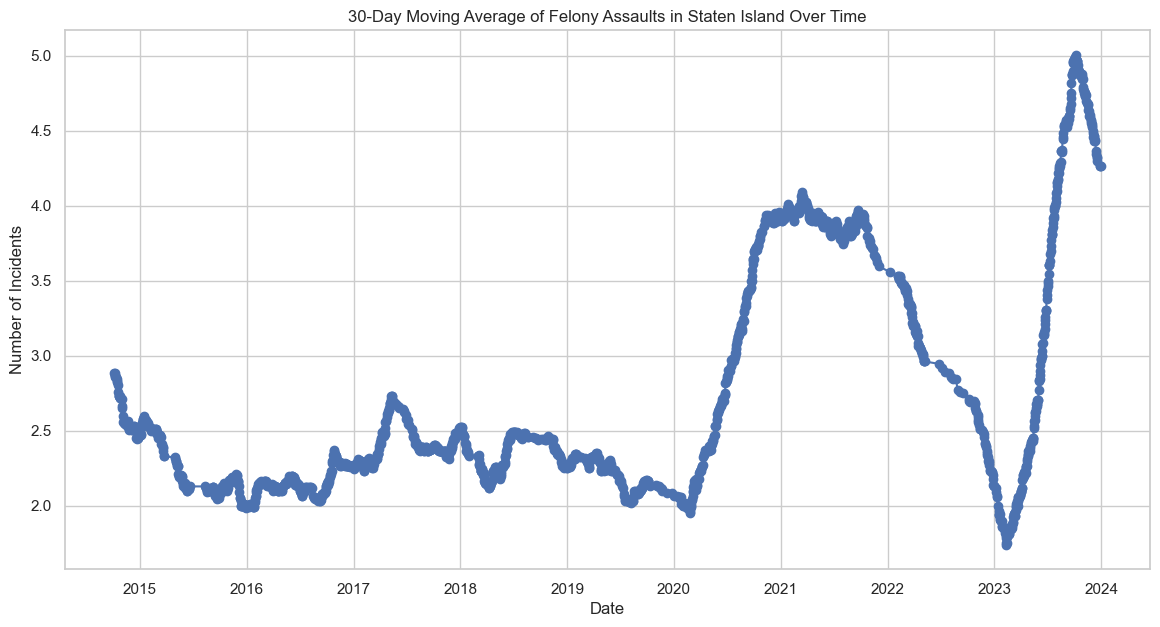

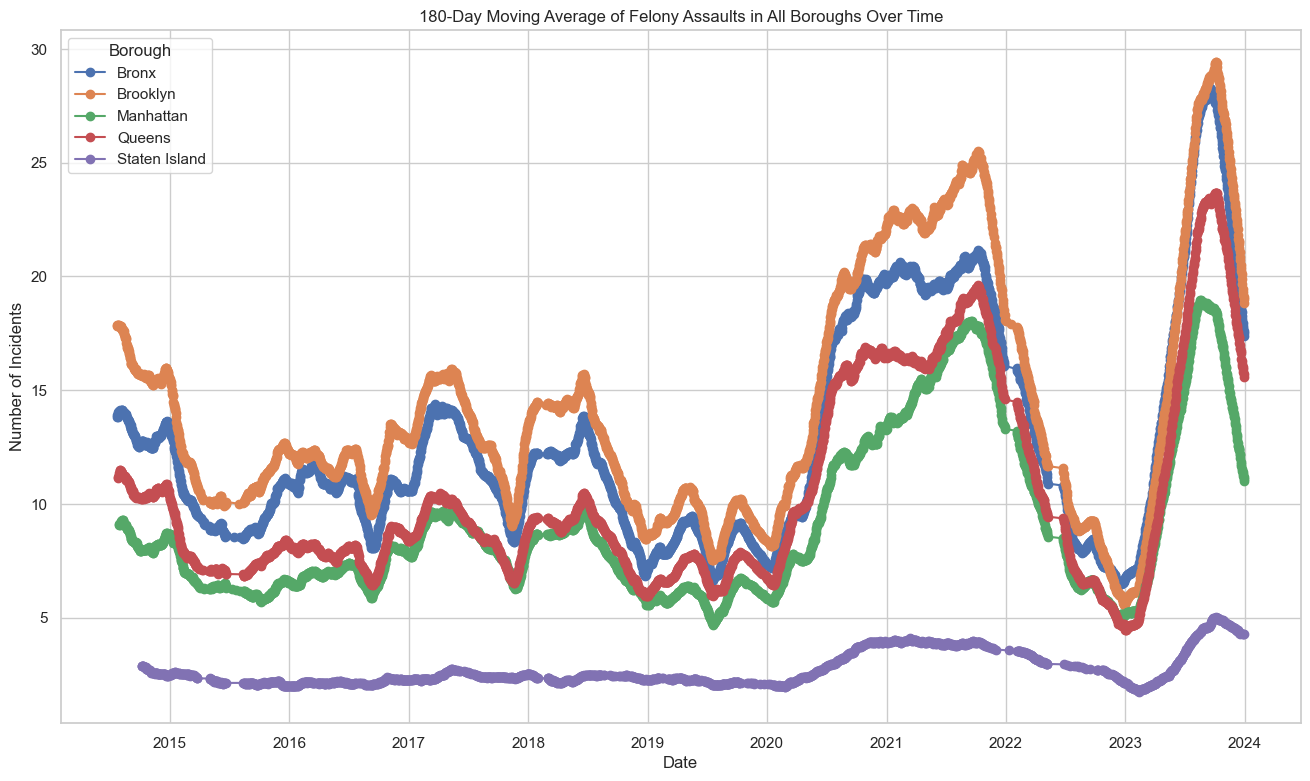

In [99]:

# Define borough keys and labels for reference
borough_labels = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
borough_keys = ['B', 'K', 'M', 'Q', 'S']

# Initialize a dictionary to store moving averages for each borough
borough_moving_averages = {}

# Define a function to plot 30-day moving average for a specific borough
def plot_felony_assaults_borough(boro_key, boro_label):
    # Filter for 'FELONY ASSAULT' in the specific borough
    felony_assault_borough = historical_df[
        (historical_df['Offense description'] == 'FELONY ASSAULT') &
        (historical_df['Arrest boro'] == boro_key)
    ]

    # Group by date and count occurrences
    date_counts = felony_assault_borough.groupby('Arrest date').size()

    # Calculate 30-day moving average
    moving_average = date_counts.rolling(window=180).mean()

    # Store the moving average in the dictionary
    borough_moving_averages[boro_label] = moving_average

    # Plotting the data with 30-day moving average
    plt.figure(figsize=(14, 7))  # Set the figure size for better visibility
    plt.plot(moving_average.index, moving_average.values, marker='o', linestyle='-', color='b')
    plt.title(f'30-Day Moving Average of Felony Assaults in {boro_label} Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Incidents')
    plt.grid(True)  # Adding a grid for better readability
    plt.show()

# Plot for each borough
for boro_key, boro_label in zip(borough_keys, borough_labels):
    plot_felony_assaults_borough(boro_key, boro_label)

# Plotting the overlay chart
plt.figure(figsize=(16, 9))  # Set the figure size for better visibility

# Plot each borough's moving average on the same plot
for boro_label in borough_labels:
    plt.plot(borough_moving_averages[boro_label].index, borough_moving_averages[boro_label].values, marker='o', linestyle='-', label=boro_label)

plt.title('180-Day Moving Average of Felony Assaults in All Boroughs Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.legend(title='Borough')
plt.grid(True)  # Adding a grid for better readability
plt.show()

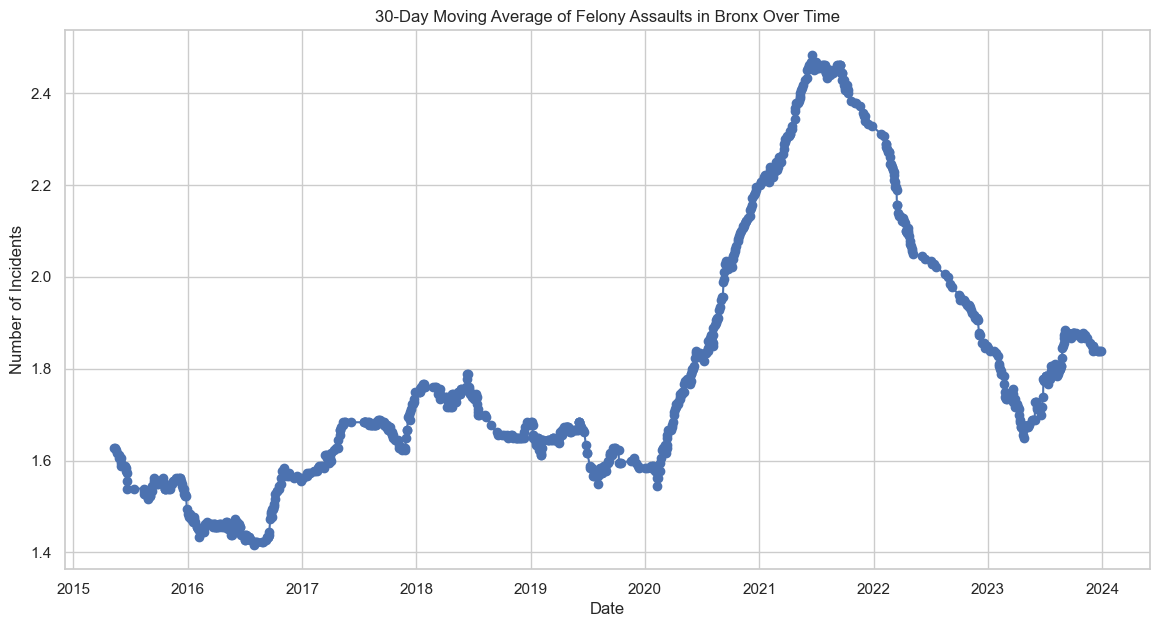

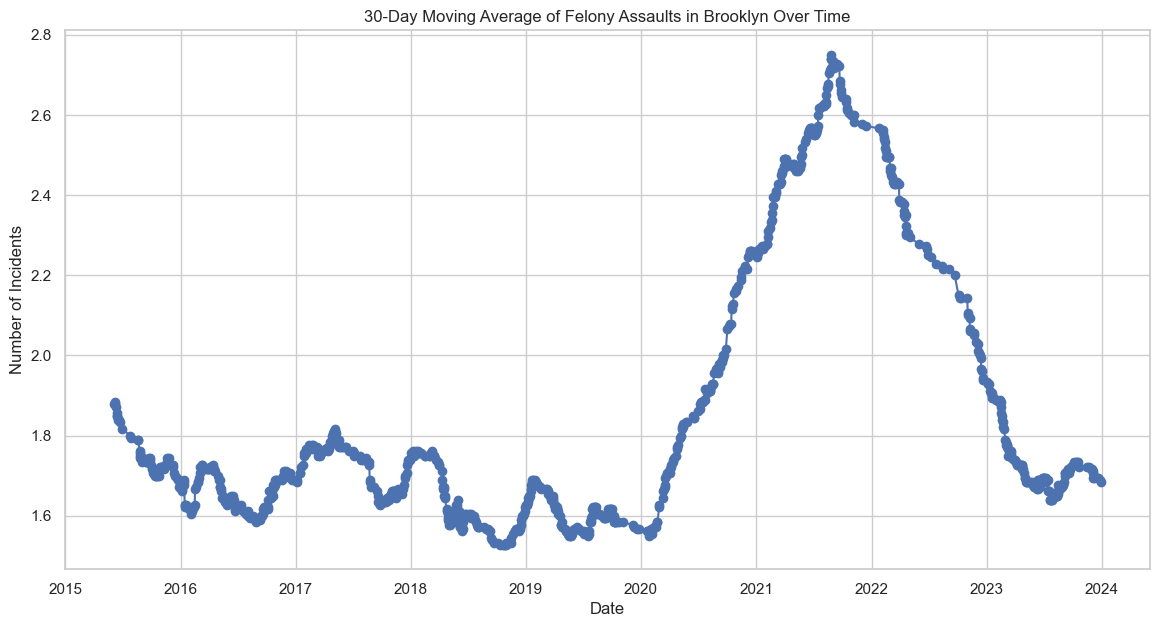

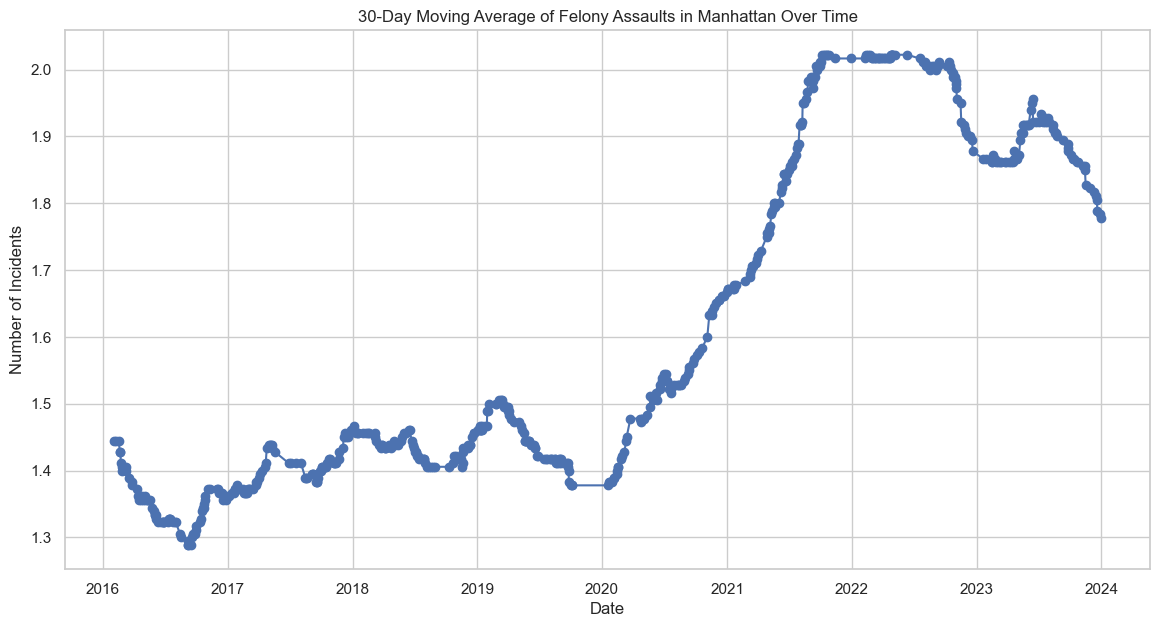

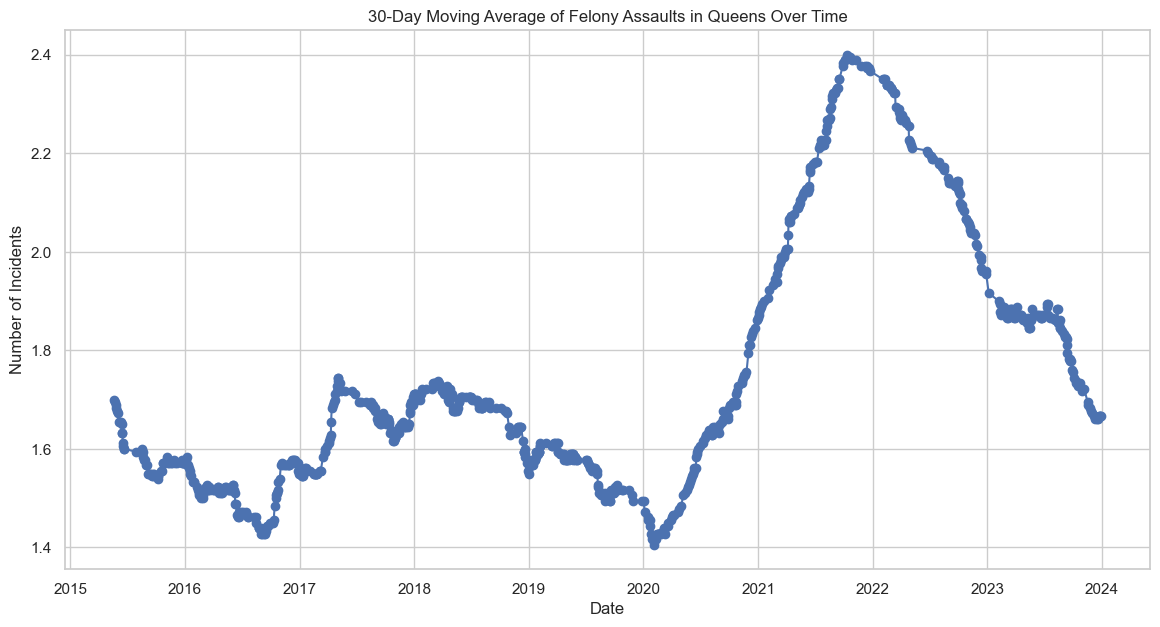

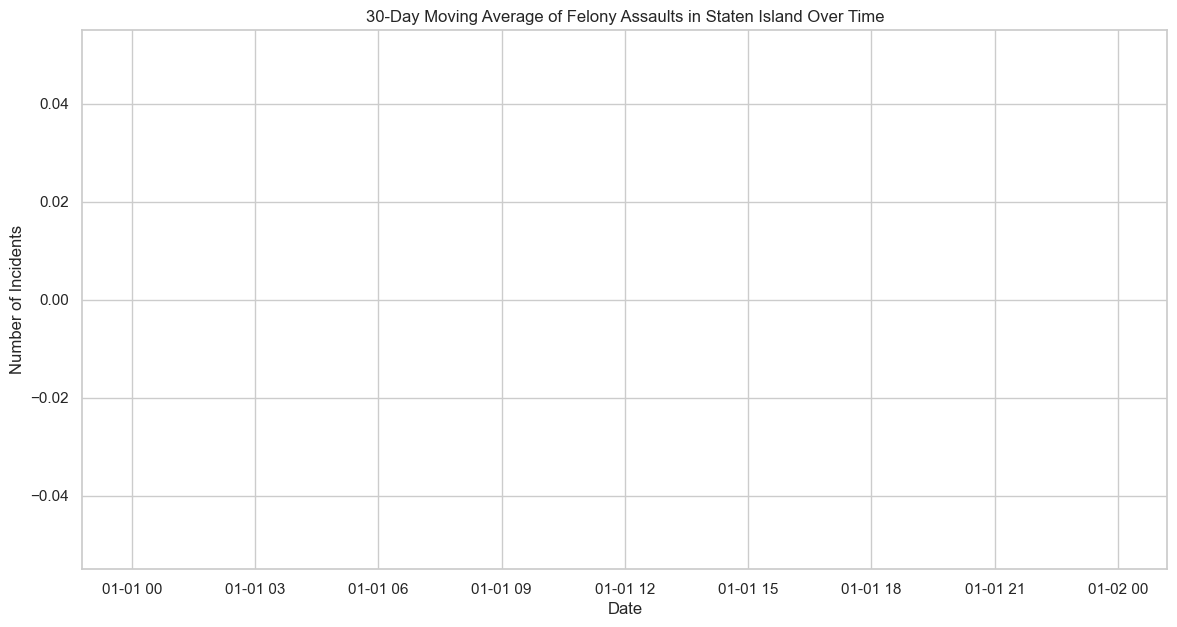

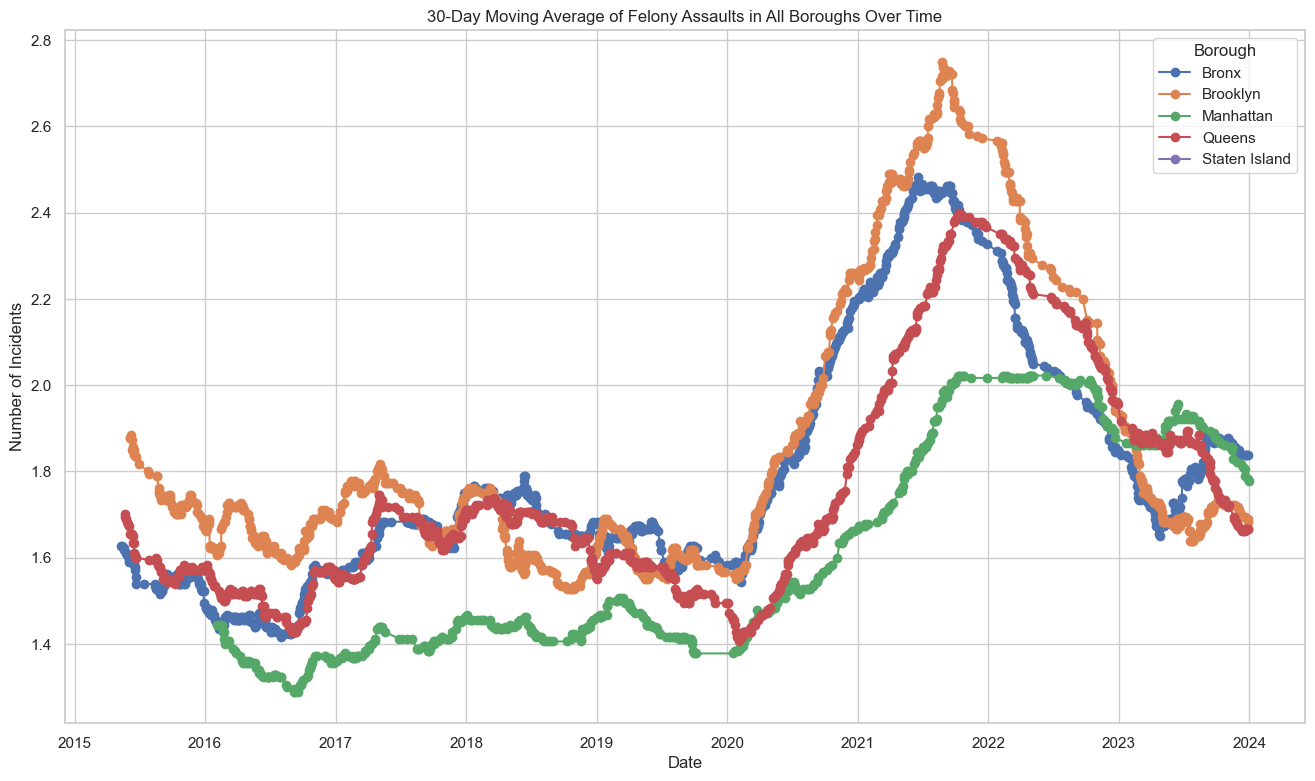

In [88]:
# Define borough keys and labels for reference
borough_labels = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
borough_keys = ['B', 'K', 'M', 'Q', 'S']

# Initialize a dictionary to store moving averages for each borough
borough_moving_averages = {}

# Define a function to plot 30-day moving average for a specific borough
def plot_felony_assaults_borough(boro_key, boro_label):
    # Filter for 'FELONY ASSAULT' in the specific borough
    felony_assault_borough = historical_df[
        (historical_df['Offense description'] == 'RAPE') &
        (historical_df['Arrest boro'] == boro_key)
    ]

    # Group by date and count occurrences
    date_counts = felony_assault_borough.groupby('Arrest date').size()

    # Calculate 30-day moving average
    moving_average = date_counts.rolling(window=180).mean()

    # Store the moving average in the dictionary
    borough_moving_averages[boro_label] = moving_average

    # Plotting the data with 30-day moving average
    plt.figure(figsize=(14, 7))  # Set the figure size for better visibility
    plt.plot(moving_average.index, moving_average.values, marker='o', linestyle='-', color='b')
    plt.title(f'30-Day Moving Average of Felony Assaults in {boro_label} Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Incidents')
    plt.grid(True)  # Adding a grid for better readability
    plt.show()

# Plot for each borough
for boro_key, boro_label in zip(borough_keys, borough_labels):
    plot_felony_assaults_borough(boro_key, boro_label)

# Plotting the overlay chart
plt.figure(figsize=(16, 9))  # Set the figure size for better visibility

# Plot each borough's moving average on the same plot
for boro_label in borough_labels:
    plt.plot(borough_moving_averages[boro_label].index, borough_moving_averages[boro_label].values, marker='o', linestyle='-', label=boro_label)

plt.title('30-Day Moving Average of Felony Assaults in All Boroughs Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.legend(title='Borough')
plt.grid(True)  # Adding a grid for better readability
plt.show()

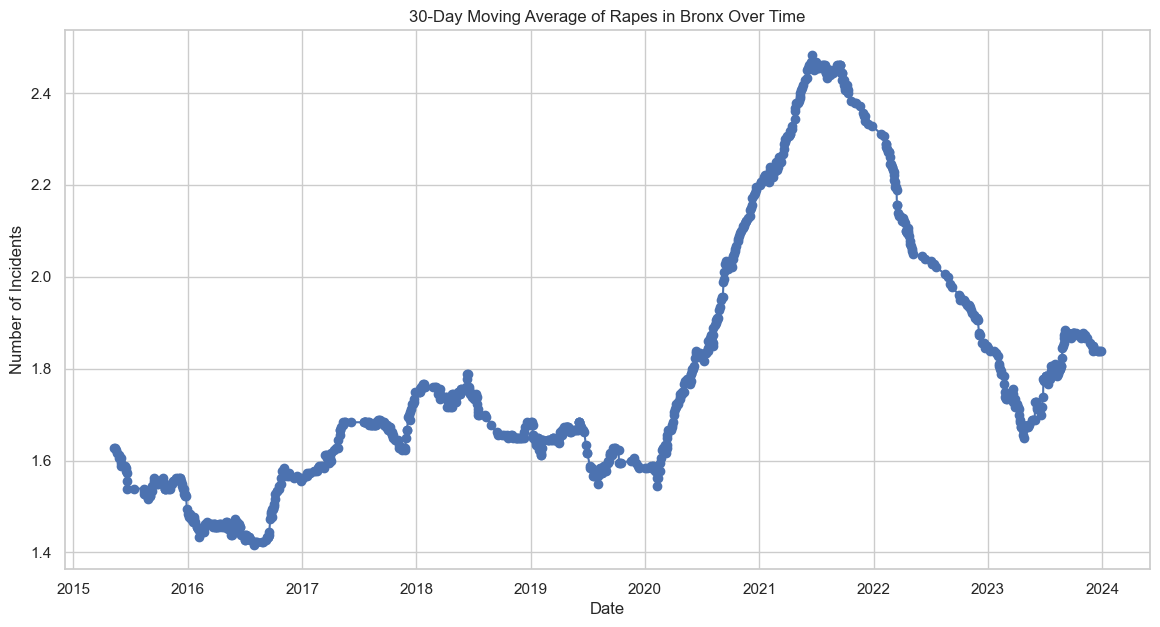

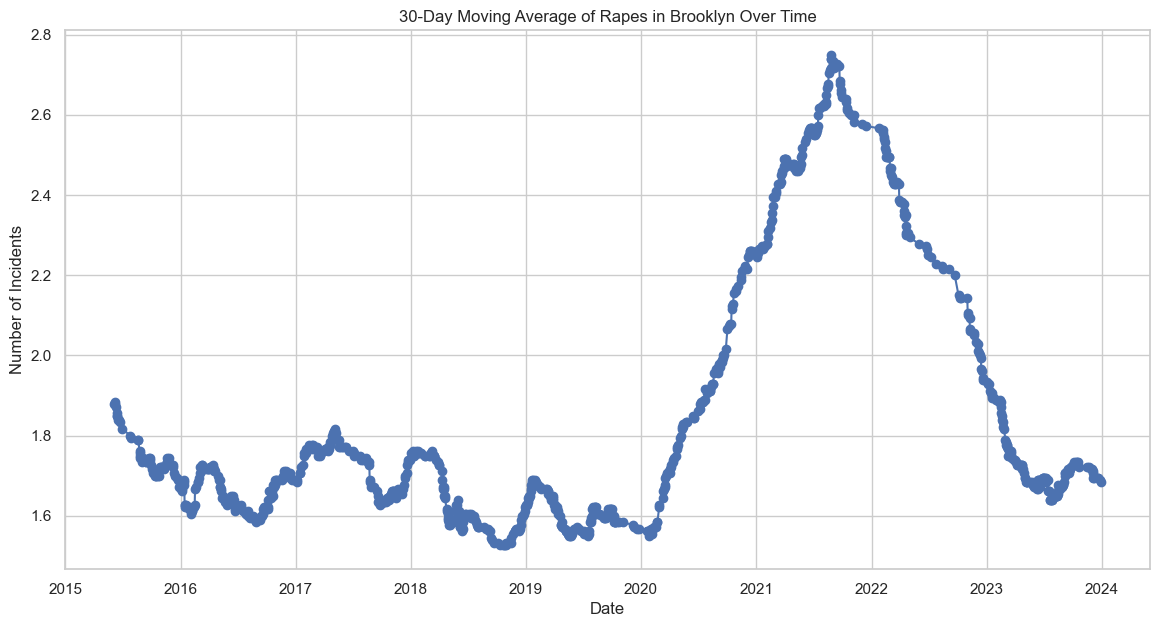

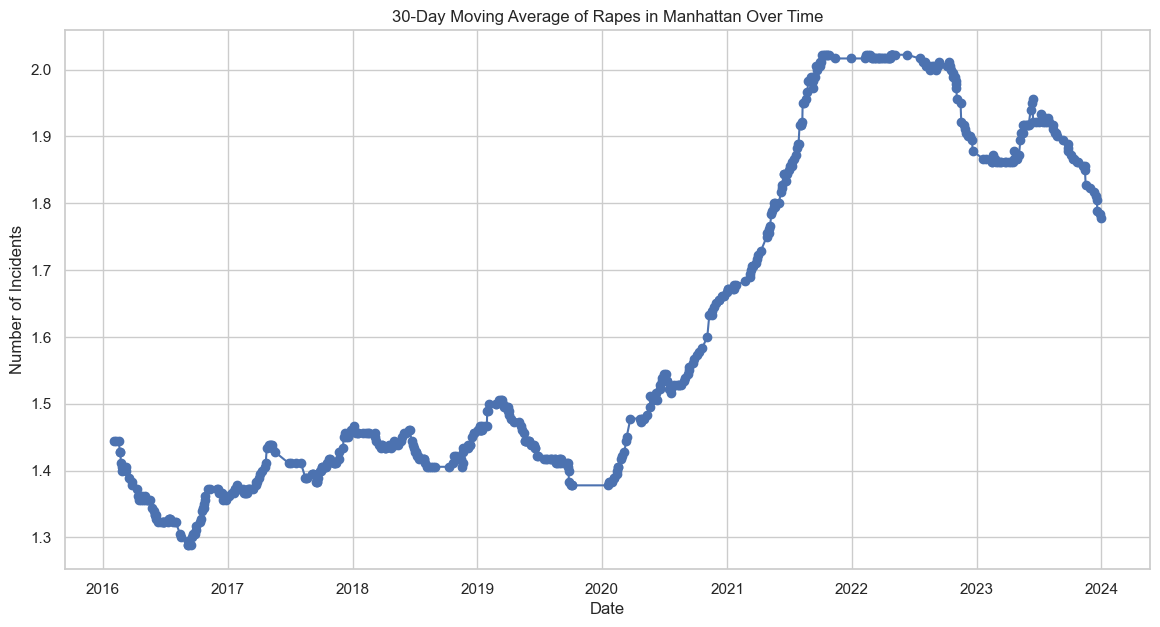

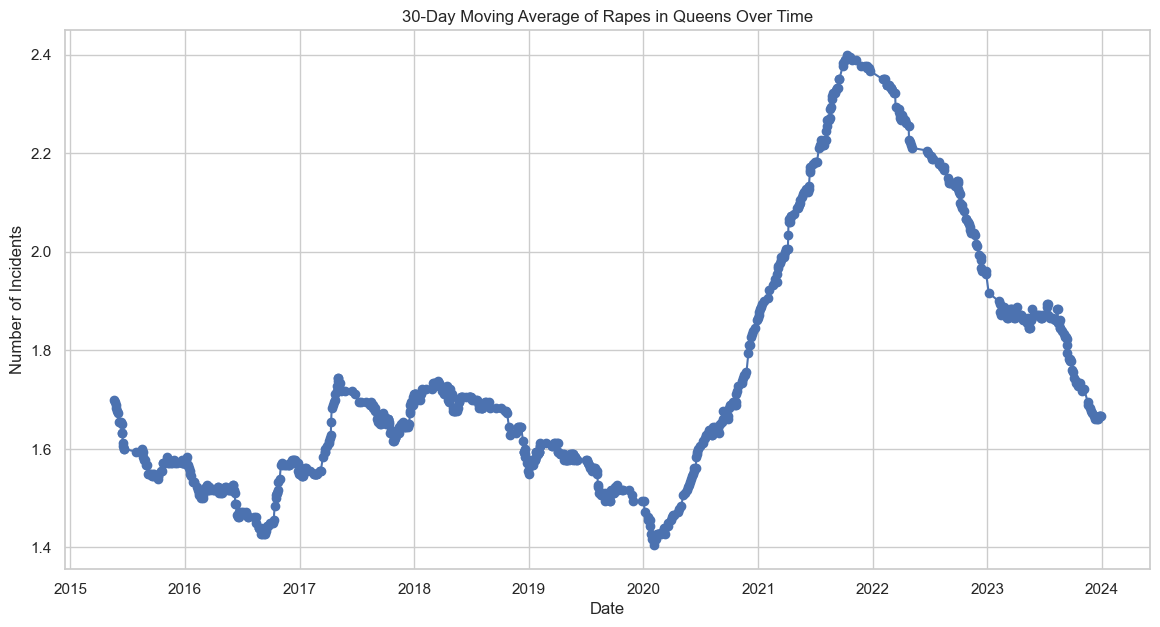

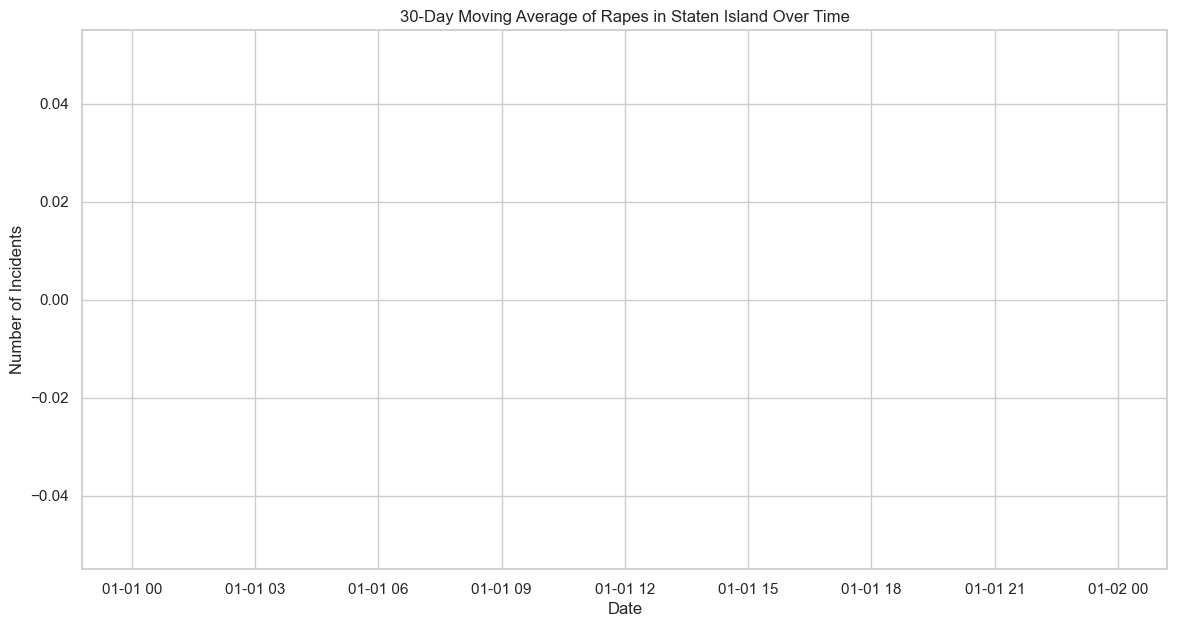

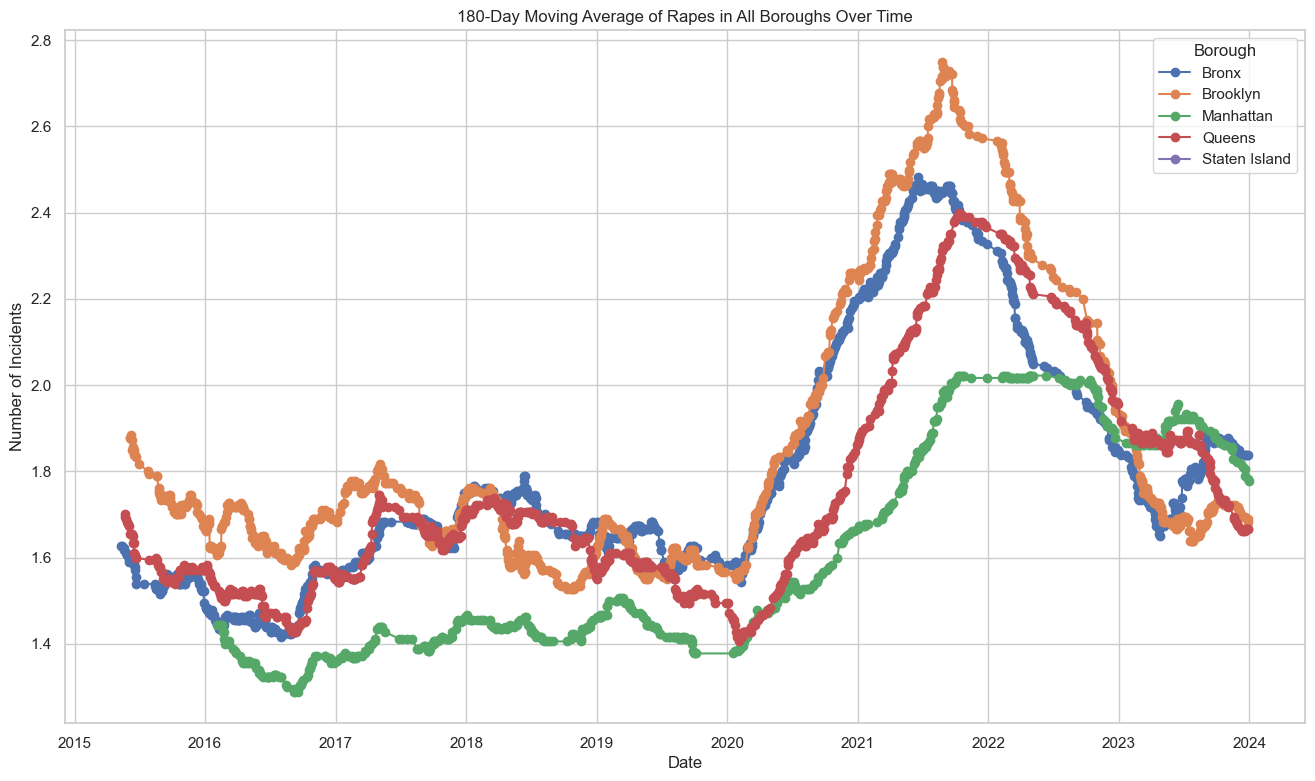

In [103]:
# Define borough keys and labels for reference
borough_labels = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
borough_keys = ['B', 'K', 'M', 'Q', 'S']

# Initialize a dictionary to store moving averages for each borough
borough_moving_averages_rape = {}

# Define a function to plot 30-day moving average for a specific borough
def plot_rape_borough(boro_key, boro_label):
    # Filter for 'RAPE' in the specific borough
    rape_borough = historical_df[
        (historical_df['Offense description'] == 'RAPE') &
        (historical_df['Arrest boro'] == boro_key)
    ]

    # Group by date and count occurrences
    date_counts = rape_borough.groupby('Arrest date').size()

    # Calculate 30-day moving average
    moving_average = date_counts.rolling(window=180).mean()

    # Store the moving average in the dictionary
    borough_moving_averages_rape[boro_label] = moving_average

    # Plotting the data with 30-day moving average
    plt.figure(figsize=(14, 7))  # Set the figure size for better visibility
    plt.plot(moving_average.index, moving_average.values, marker='o', linestyle='-', color='b')
    plt.title(f'30-Day Moving Average of Rapes in {boro_label} Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Incidents')
    plt.grid(True)  # Adding a grid for better readability
    plt.show()

# Plot for each borough
for boro_key, boro_label in zip(borough_keys, borough_labels):
    plot_rape_borough(boro_key, boro_label)

# Plotting the overlay chart
plt.figure(figsize=(16, 9))  # Set the figure size for better visibility

# Plot each borough's moving average on the same plot
for boro_label in borough_labels:
    plt.plot(borough_moving_averages_rape[boro_label].index, borough_moving_averages_rape[boro_label].values, marker='o', linestyle='-', label=boro_label)

plt.title('180-Day Moving Average of Rapes in All Boroughs Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.legend(title='Borough')
plt.grid(True)  # Adding a grid for better readability
plt.show()

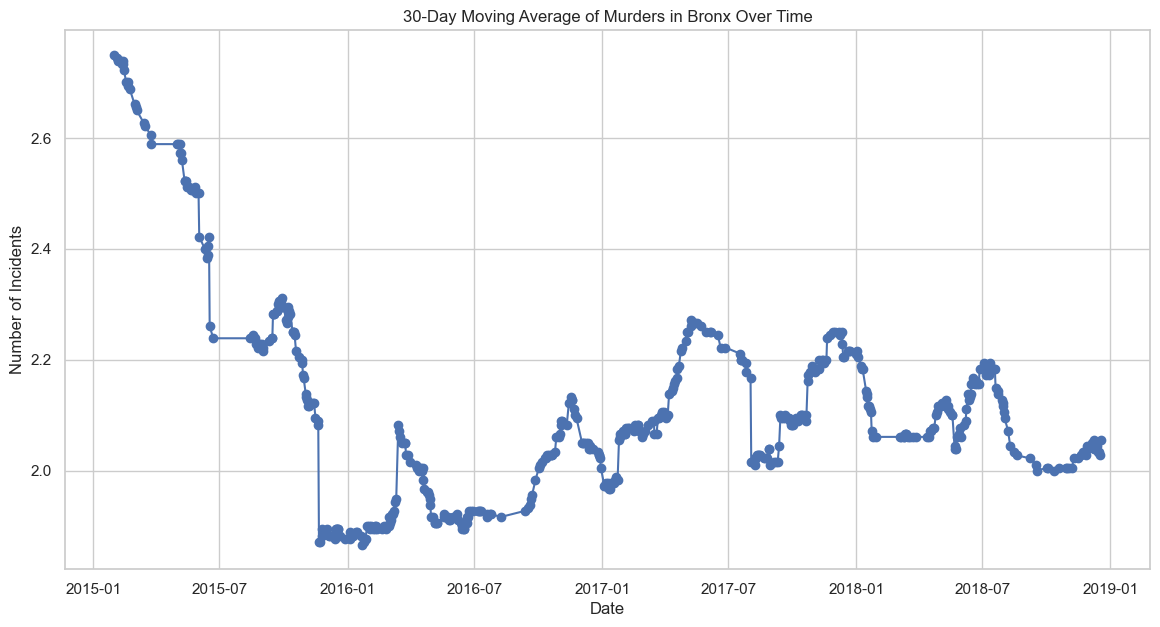

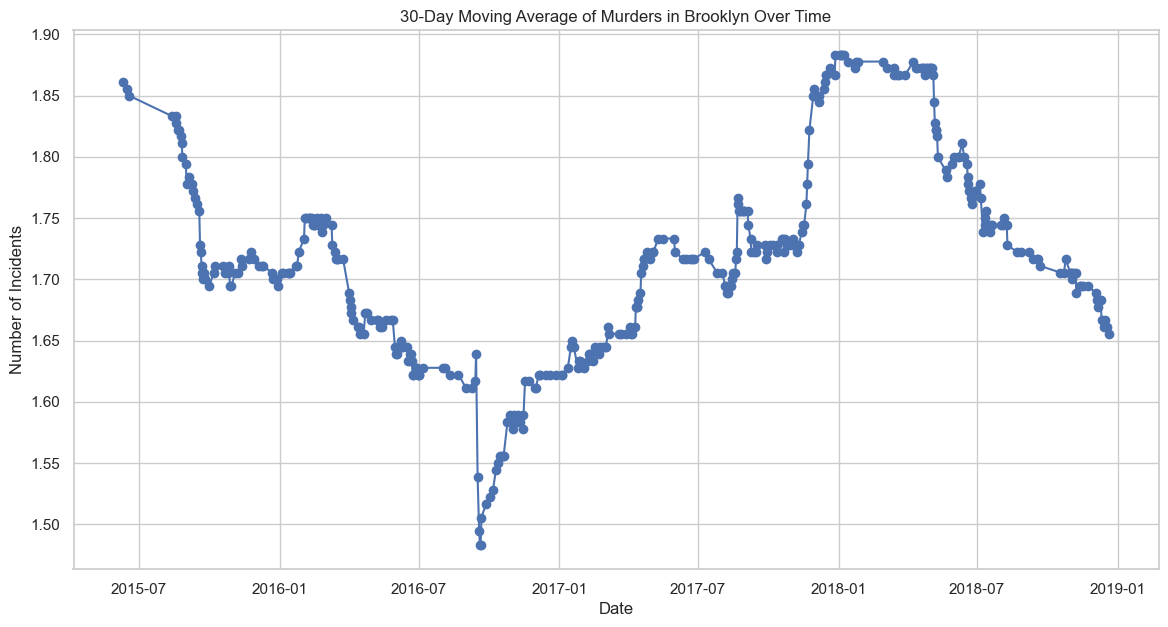

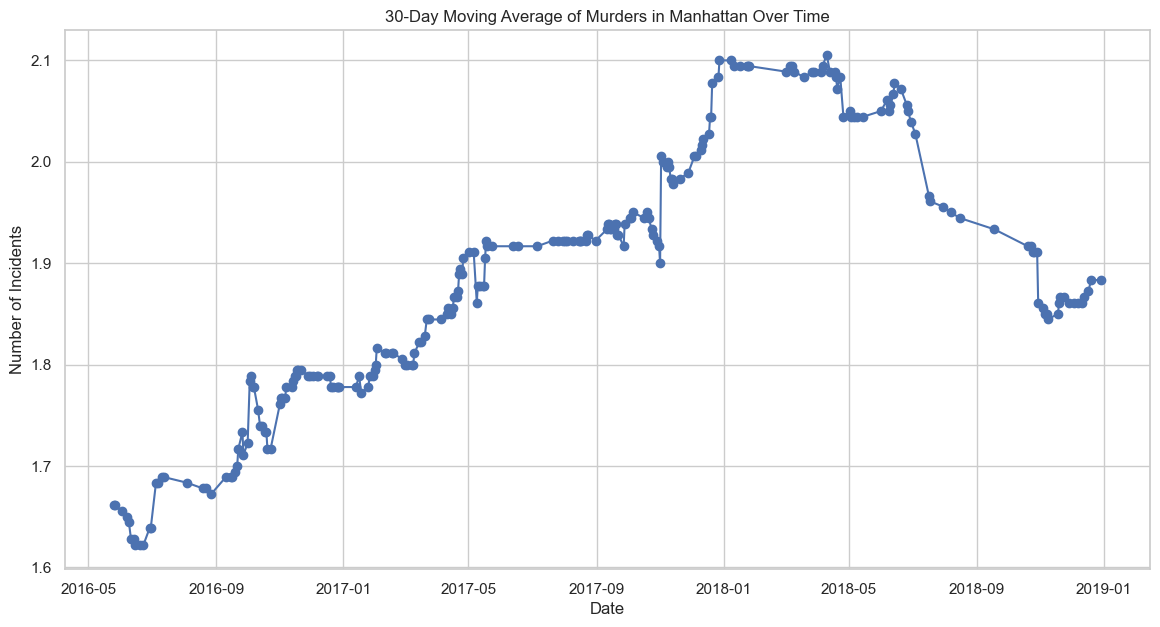

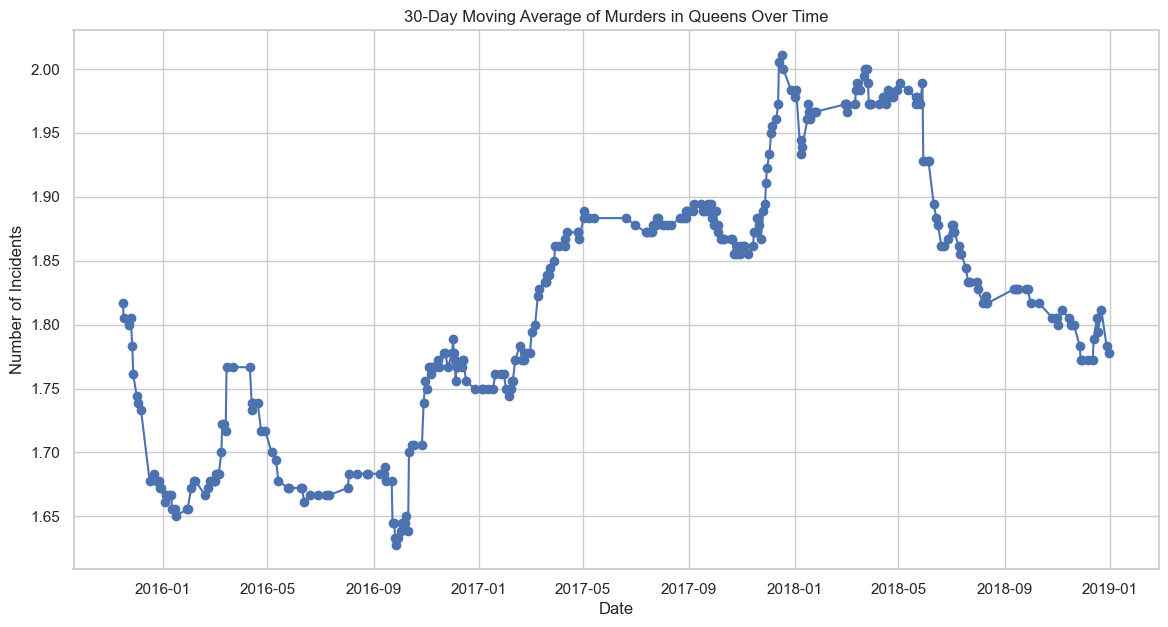

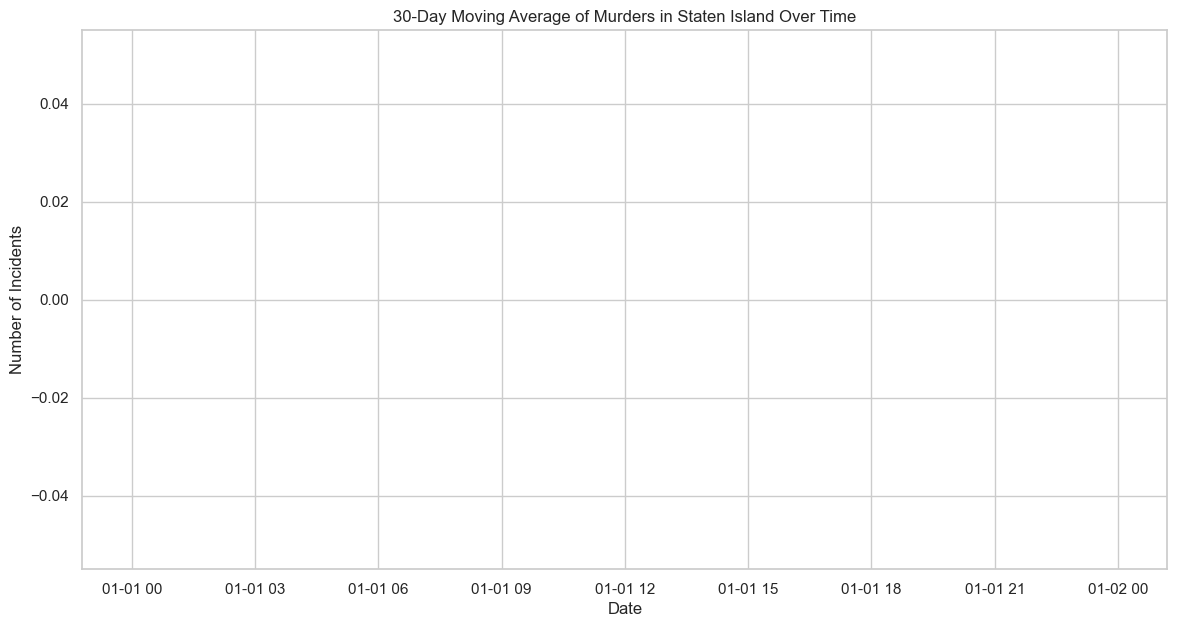

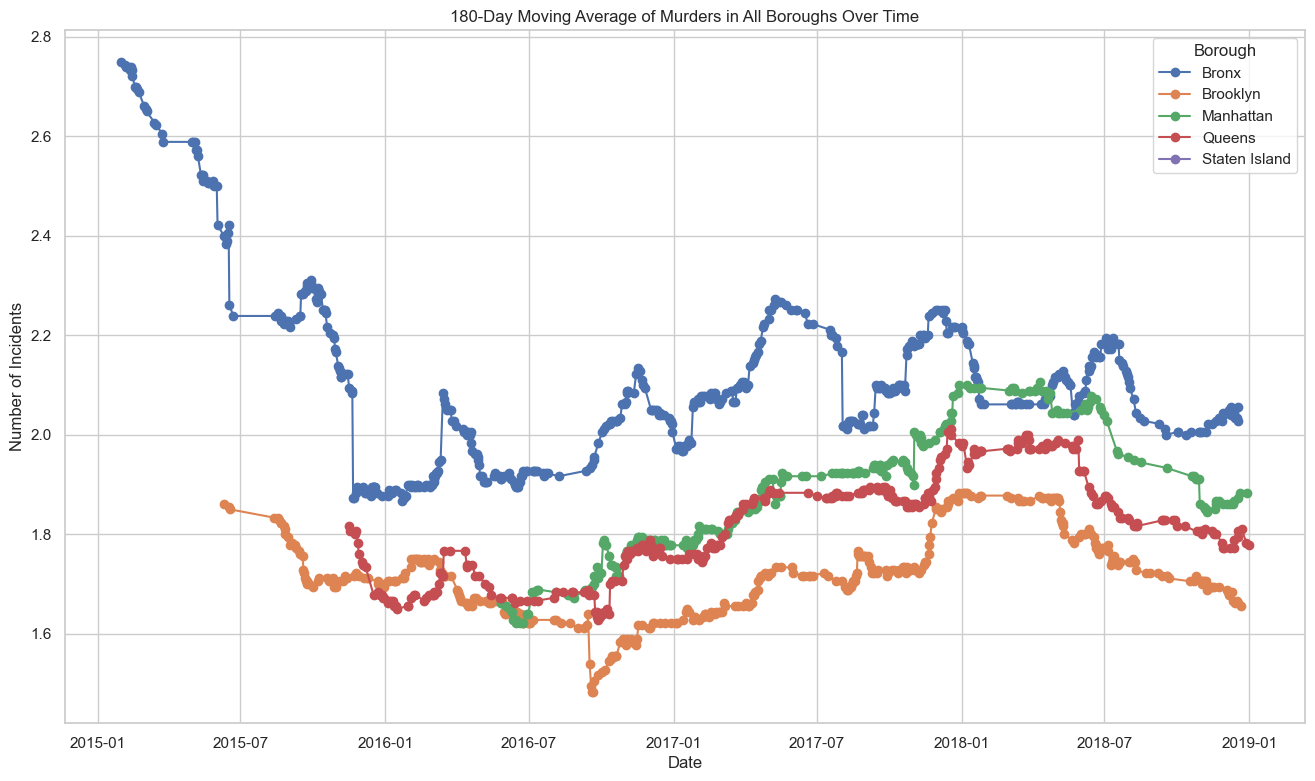

In [102]:
# Initialize a dictionary to store moving averages for each borough
borough_moving_averages_murder = {}

# Define a function to plot 30-day moving average for a specific borough
def plot_murder_borough(boro_key, boro_label):
    # Filter for 'MURDER' in the specific borough
    murder_borough = historical_df[
        (historical_df['Offense description'] == 'MURDER & NON-NEGL. MANSLAUGHTER') &
        (historical_df['Arrest boro'] == boro_key)
    ]

    # Group by date and count occurrences
    date_counts = murder_borough.groupby('Arrest date').size()

    # Calculate 30-day moving average
    moving_average = date_counts.rolling(window=180).mean()

    # Store the moving average in the dictionary
    borough_moving_averages_murder[boro_label] = moving_average

    # Plotting the data with 30-day moving average
    plt.figure(figsize=(14, 7))  # Set the figure size for better visibility
    plt.plot(moving_average.index, moving_average.values, marker='o', linestyle='-', color='b')
    plt.title(f'30-Day Moving Average of Murders in {boro_label} Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Incidents')
    plt.grid(True)  # Adding a grid for better readability
    plt.show()

# Plot for each borough
for boro_key, boro_label in zip(borough_keys, borough_labels):
    plot_murder_borough(boro_key, boro_label)

# Plotting the overlay chart
plt.figure(figsize=(16, 9))  # Set the figure size for better visibility

# Plot each borough's moving average on the same plot
for boro_label in borough_labels:
    plt.plot(borough_moving_averages_murder[boro_label].index, borough_moving_averages_murder[boro_label].values, marker='o', linestyle='-', label=boro_label)

plt.title('180-Day Moving Average of Murders in All Boroughs Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.legend(title='Borough')
plt.grid(True)  # Adding a grid for better readability
plt.show()

In [22]:
offense_counts_2023 = historical_df['Offense description'].value_counts()
# Sort offenses by counts in descending order
sorted_offenses_2023 = offense_counts_2023.sort_values(ascending=False)
top_15_offenses_2023 = sorted_offenses_2023.head(15)
# Select the top 5 offenses 2023
top_5_offenses_2023 = sorted_offenses_2023.head(5)

In [23]:
# Set the base URL
base_url = "https://data.cityofnewyork.us/resource/uip8-fykc.json?"
# Set the query URL
query_url = base_url + "$limit=50000"
response = requests.get(query_url).json()
# Create a DataFrame
try:
    original_df = pd.DataFrame(response)
except : 
    print("Something went wrong...")
# Display original df
original_df

arrest_key              arrest_date pd_cd  \
0      280255493  2024-01-10T00:00:00.000   397   
1      279805419  2024-01-02T00:00:00.000   157   
2      279895750  2024-01-03T00:00:00.000   101   
3      280809090  2024-01-19T00:00:00.000   511   
4      280357135  2024-01-11T00:00:00.000   109   
...          ...                      ...   ...   
49995  283662436  2024-03-12T00:00:00.000   268   
49996  284068720  2024-03-20T00:00:00.000   105   
49997  283384015  2024-03-07T00:00:00.000   114   
49998  283729925  2024-03-14T00:00:00.000   101   
49999  283700123  2024-03-13T00:00:00.000   503   

                              pd_desc ky_cd                       ofns_desc  \
0      ROBBERY,OPEN AREA UNCLASSIFIED   105                         ROBBERY   
1                              RAPE 1   104                            RAPE   
2                           ASSAULT 3   344    ASSAULT 3 & RELATED OFFENSES   
3      CONTROLLED SUBSTANCE, POSSESSI   235                 DANGEROUS DRUGS   
4            ASSAULT 2,1,UNCLASSIFIED   106                  FELONY ASSAULT   
...                               ...   ...                             ...   
49995              CRIMINAL MIS 2 & 3   121  CRIMINAL MISCHIEF & RELATED OF   
49996               STRANGULATION 1ST   106                  FELONY ASSAULT   
49997             OBSTR BREATH/CIRCUL   344    ASSAULT 3 & RELATED OFFENSES   
49998                       ASSAULT 3   344    ASSAULT 3 & RELATED OFFENSES   
49999  CONTROLLED SUBSTANCE,INTENT TO   117                 DANGEROUS DRUGS   

         law_code law_cat_cd arrest_boro arrest_precinct  ... x_coord_cd  \
0      PL 1601001          F           M              26  ...     996342   
1      PL 1303501          F           K              77  ...    1003509   
2      PL 1200001          M           Q             106  ...    1026836   
3      PL 2200300          M           B              49  ...    1027430   
4      PL 1200502          F           K              81  ...    1002457   
...           ...        ...         ...             ...  ...        ...   
49995  PL 1450502          F           K              84  ...     988174   
49996  PL 1211300          F           M              25  ...    1002076   
49997  PL 121110A          M           M              28  ...     997373   
49998  PL 1200001          M           B              48  ...    1015629   
49999  PL 2201601          F           Q             102  ...    1030409   

      y_coord_cd            latitude           longitude  \
0         236149           40.814845          -73.956312   
1         185018    40.6744956865259   -73.9305713255961   
2         180689           40.662526          -73.846499   
3         251104           40.855793          -73.843908   
4         192292           40.694456          -73.934343   
...          ...                 ...                 ...   
49995     190975           40.690859          -73.985848   
49996     231440           40.801908          -73.935612   
49997     231879           40.803121          -73.952599   
49998     246174           40.842311          -73.886588   
49999     189906  40.687804468530956  -73.83356012817558   

                                         geocoded_column  \
0      {'type': 'Point', 'coordinates': [-73.956312, ...   
1      {'type': 'Point', 'coordinates': [-73.93057132...   
2      {'type': 'Point', 'coordinates': [-73.846499, ...   
3      {'type': 'Point', 'coordinates': [-73.843908, ...   
4      {'type': 'Point', 'coordinates': [-73.934343, ...   
...                                                  ...   
49995  {'type': 'Point', 'coordinates': [-73.985848, ...   
49996  {'type': 'Point', 'coordinates': [-73.935612, ...   
49997  {'type': 'Point', 'coordinates': [-73.952599, ...   
49998  {'type': 'Point', 'coordinates': [-73.886588, ...   
49999  {'type': 'Point', 'coordinates': [-73.83356012...   

      :@computed_region_f5dn_yrer :@computed_region_yeji_bk3q  \
0                       

In [24]:
original_df.drop(columns=['pd_cd','pd_desc','law_cat_cd','arrest_key','arrest_precinct','x_coord_cd', 'y_coord_cd', 'ky_cd',\
                           'jurisdiction_code', ':@computed_region_f5dn_yrer', ':@computed_region_yeji_bk3q',\
                            ':@computed_region_92fq_4b7q', ':@computed_region_sbqj_enih', ':@computed_region_efsh_h5xi',\
                                'law_code'], inplace=True)

In [25]:
original_df.dropna(inplace=True)
original_df =original_df[original_df['arrest_date'] != 'null']
original_df =original_df[original_df['ofns_desc'] != 'null']

In [26]:
original_df.columns

Index(['arrest_date', 'ofns_desc', 'arrest_boro', 'age_group', 'perp_sex',
       'perp_race', 'latitude', 'longitude', 'geocoded_column'],
      dtype='object')

In [27]:
original_df.rename(columns=new_column_names,inplace=True)
original_df.columns

Index(['Arrest date', 'Offense description', 'Arrest boro', 'Age group', 'Sex',
       'Race', 'Latitude', 'Longitude', 'geocoded_column'],
      dtype='object')

In [28]:
original_df

Arrest date             Offense description Arrest boro  \
0      2024-01-10T00:00:00.000                         ROBBERY           M   
1      2024-01-02T00:00:00.000                            RAPE           K   
2      2024-01-03T00:00:00.000    ASSAULT 3 & RELATED OFFENSES           Q   
3      2024-01-19T00:00:00.000                 DANGEROUS DRUGS           B   
4      2024-01-11T00:00:00.000                  FELONY ASSAULT           K   
...                        ...                             ...         ...   
49995  2024-03-12T00:00:00.000  CRIMINAL MISCHIEF & RELATED OF           K   
49996  2024-03-20T00:00:00.000                  FELONY ASSAULT           M   
49997  2024-03-07T00:00:00.000    ASSAULT 3 & RELATED OFFENSES           M   
49998  2024-03-14T00:00:00.000    ASSAULT 3 & RELATED OFFENSES           B   
49999  2024-03-13T00:00:00.000                 DANGEROUS DRUGS           Q   

      Age group Sex            Race            Latitude           Longitude  \
0           <18   M           BLACK           40.814845          -73.956312   
1         25-44   M  WHITE HISPANIC    40.6744956865259   -73.9305713255961   
2           65+   F           WHITE           40.662526          -73.846499   
3         45-64   M           BLACK           40.855793          -73.843908   
4         25-44   F           BLACK           40.694456          -73.934343   
...         ...  ..             ...                 ...                 ...   
49995       65+   F           BLACK           40.690859          -73.985848   
49996     25-44   M  BLACK HISPANIC           40.801908          -73.935612   
49997     25-44   M           BLACK           40.803121          -73.952599   
49998     25-44   F  WHITE HISPANIC           40.842311          -73.886588   
49999     25-44   M  WHITE HISPANIC  40.687804468530956  -73.83356012817558   

                                         geocoded_column  
0      {'type': 'Point', 'coordinates': [-73.956312, ...  
1      {'type': 'Point', 'coordinates': [-73.93057132...  
2      {'type': 'Point', 'coordinates': [-73.846499, ...  
3      {'type': 'Point', 'coordinates': [-73.843908, ...  
4      {'type': 'Point', 'coordinates': [-73.934343, ...  
...                                                  ...  
49995  {'type': 'Point', 'coordinates': [-73.985848, ...  
49996  {'type': 'Point', 'coordinates': [-73.935612, ...  
49997  {'type': 'Point', 'coordinates': [-73.952599, ...  
49998  {'type': 'Point', 'coordinates': [-73.886588, ...  
49999  {'type': 'Point', 'coordinates': [-73.83356012...  

[50000 rows x 9 columns]

In [29]:
pd.set_option('display.max_rows', 200)

In [30]:
original_df['Offense description'].value_counts()

Offense description
ASSAULT 3 & RELATED OFFENSES            6940
PETIT LARCENY                           5048
FELONY ASSAULT                          4079
DANGEROUS DRUGS                         3787
VEHICLE AND TRAFFIC LAWS                3183
MISCELLANEOUS PENAL LAW                 3148
GRAND LARCENY                           2431
ROBBERY                                 2358
CRIMINAL MISCHIEF & RELATED OF          2243
DANGEROUS WEAPONS                       1951
OTHER OFFENSES RELATED TO THEF          1765
OFFENSES AGAINST PUBLIC ADMINI          1538
BURGLARY                                1249
OFFENSES INVOLVING FRAUD                1103
SEX CRIMES                              1070
FORGERY                                 1009
OFF. AGNST PUB ORD SENSBLTY &            880
POSSESSION OF STOLEN PROPERTY            861
CRIMINAL TRESPASS                        607
OTHER TRAFFIC INFRACTION                 596
INTOXICATED & IMPAIRED DRIVING           505
GRAND LARCENY OF MOTOR VEHICLE     

In [31]:
offense_counts_2024 = original_df['Offense description'].value_counts()
# Sort offenses by counts in descending order
sorted_offenses_2024 = offense_counts_2024.sort_values(ascending=False)
top_15_offenses_2024 = sorted_offenses_2024.head(15)
# Select the top 5 offenses 2024
top_5_offenses_2024 = sorted_offenses_2024.head(5)

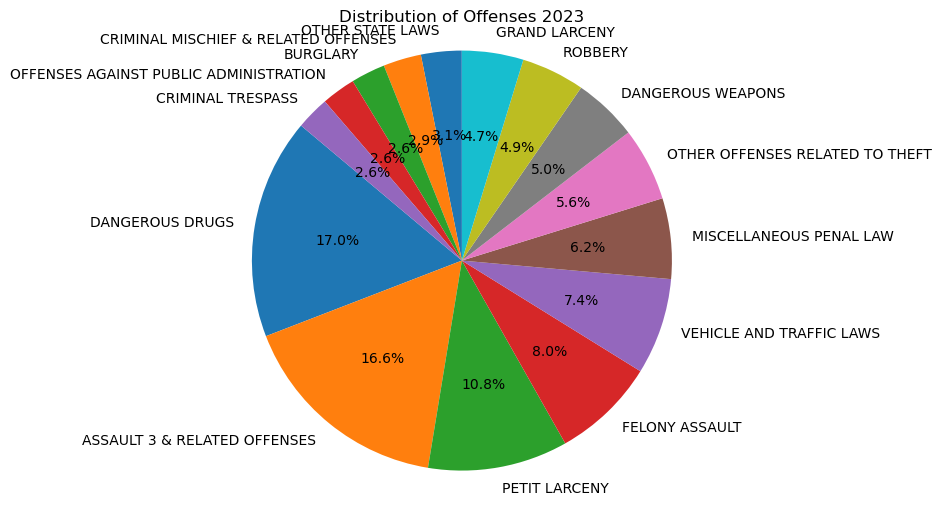

In [32]:
# Plot the top 15 offenses2023
showPieChart(top_15_offenses_2023,"2023")

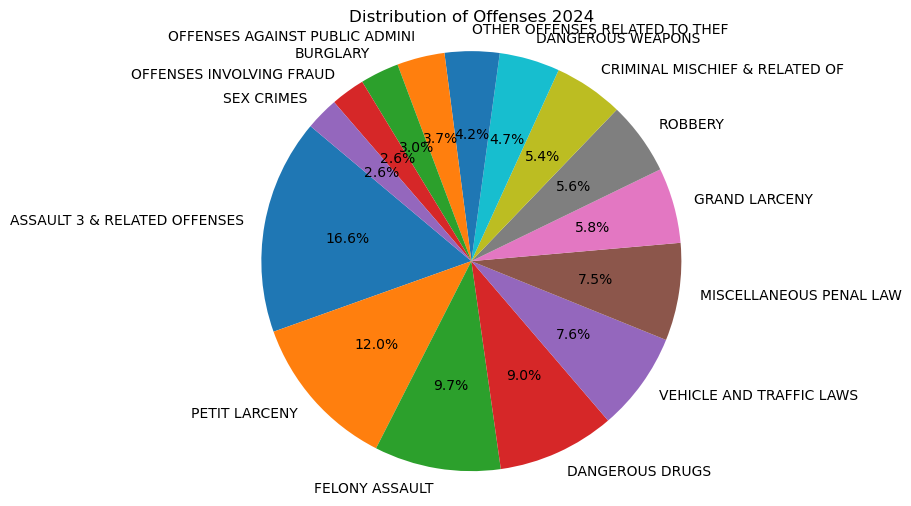

In [33]:
# Plot the top 15 offenses 2024
showPieChart(top_15_offenses_2024,"2024")

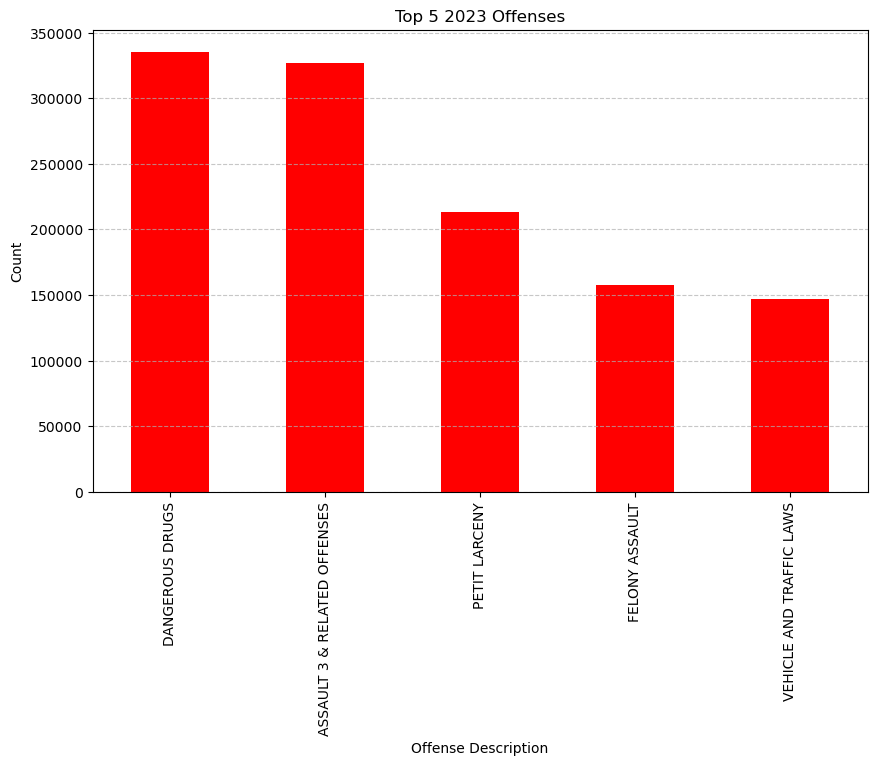

In [34]:
# Plot the top 5 offenses 2023
showChart(top_5_offenses_2023,"2023")

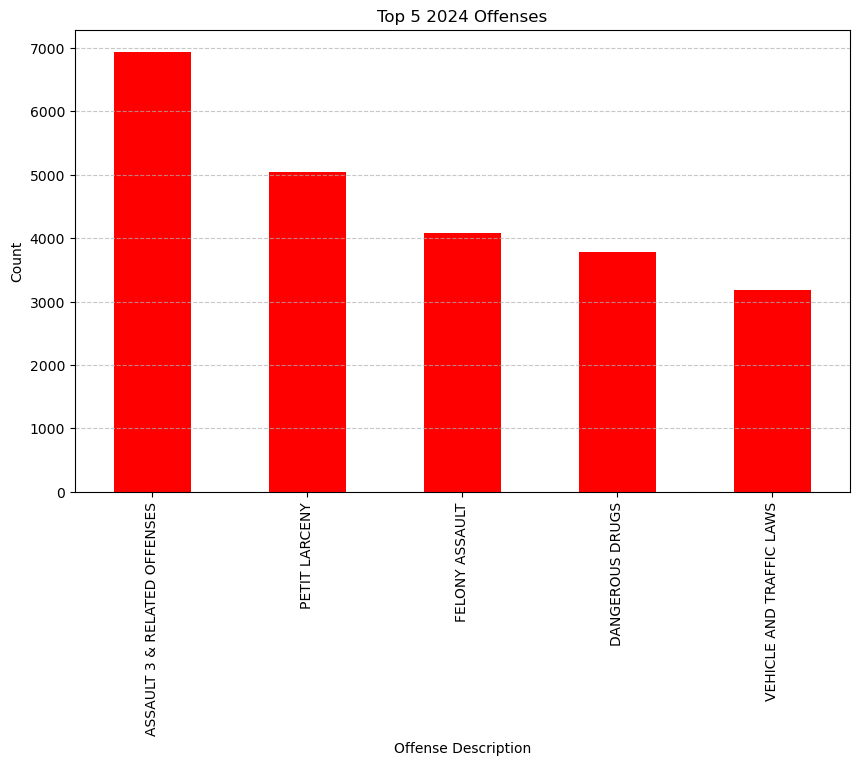

In [35]:
# Plot the top 5 offenses 2024
showChart(top_5_offenses_2024,"2024")

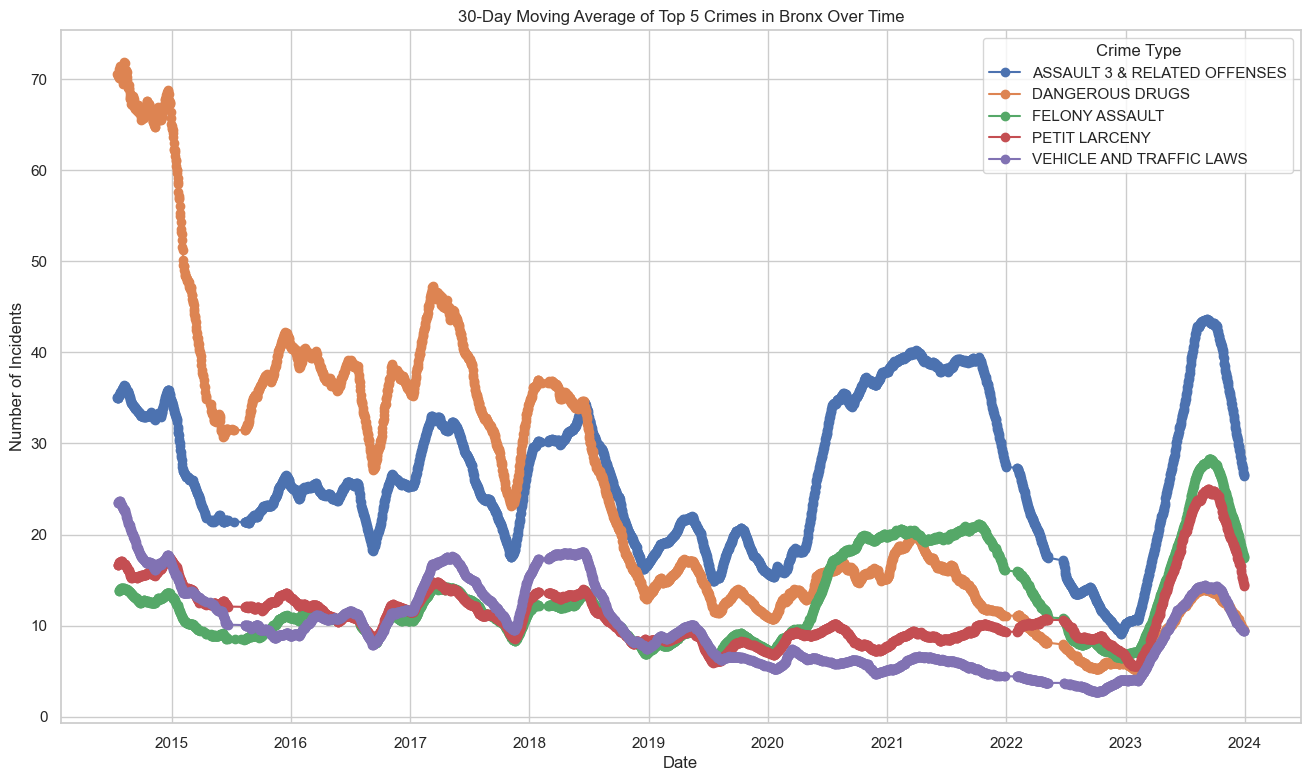

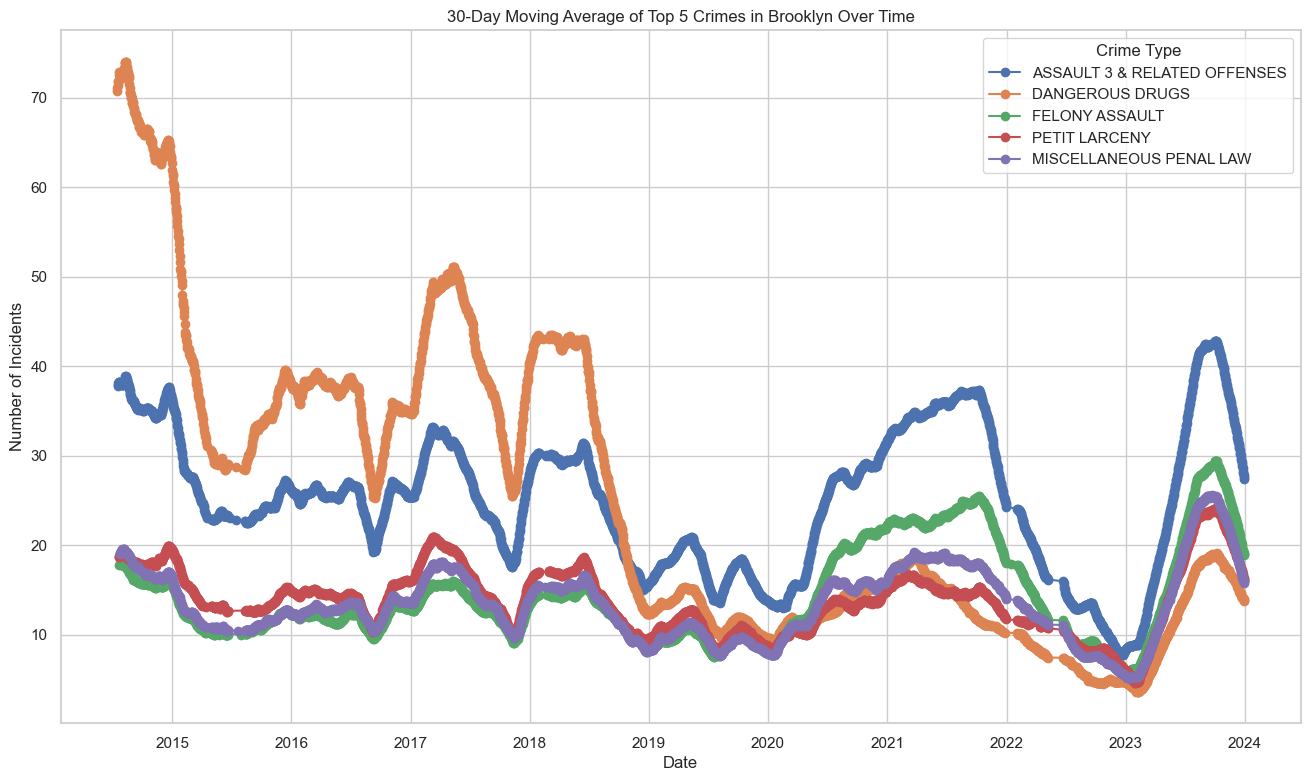

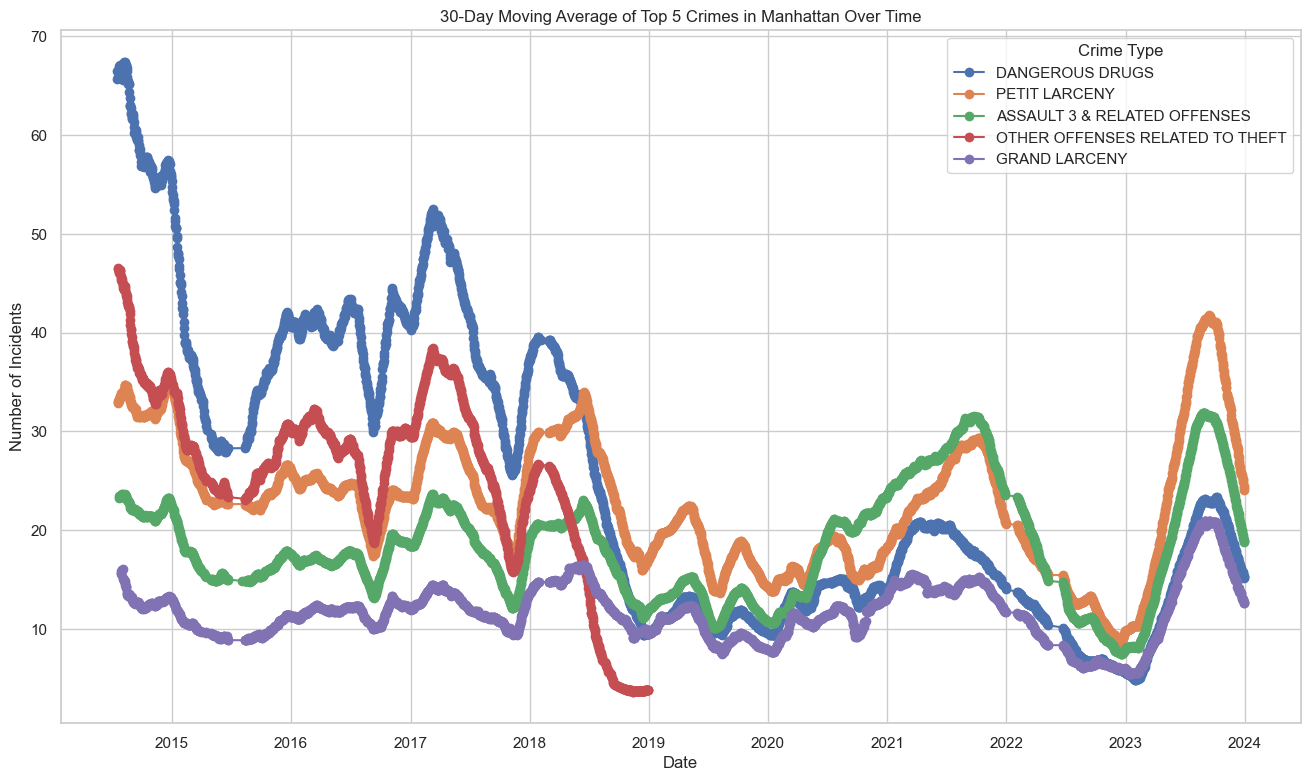

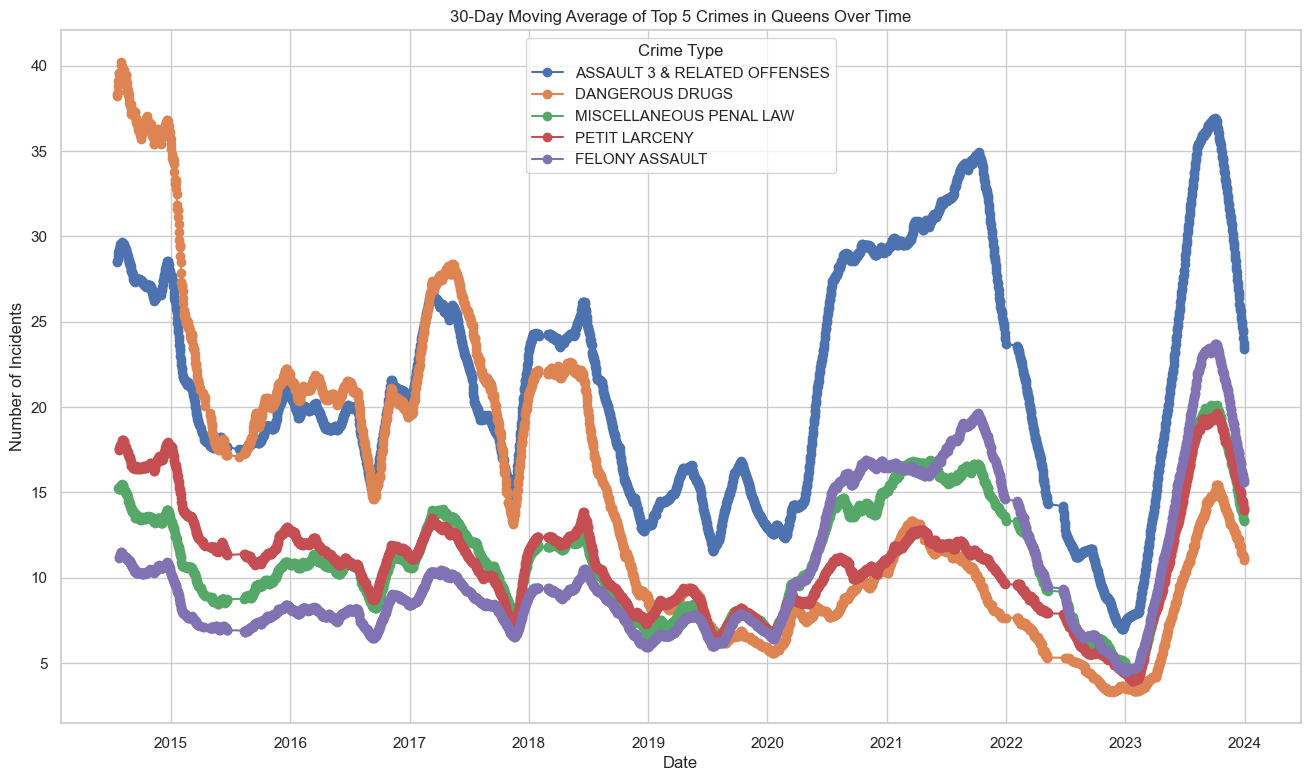

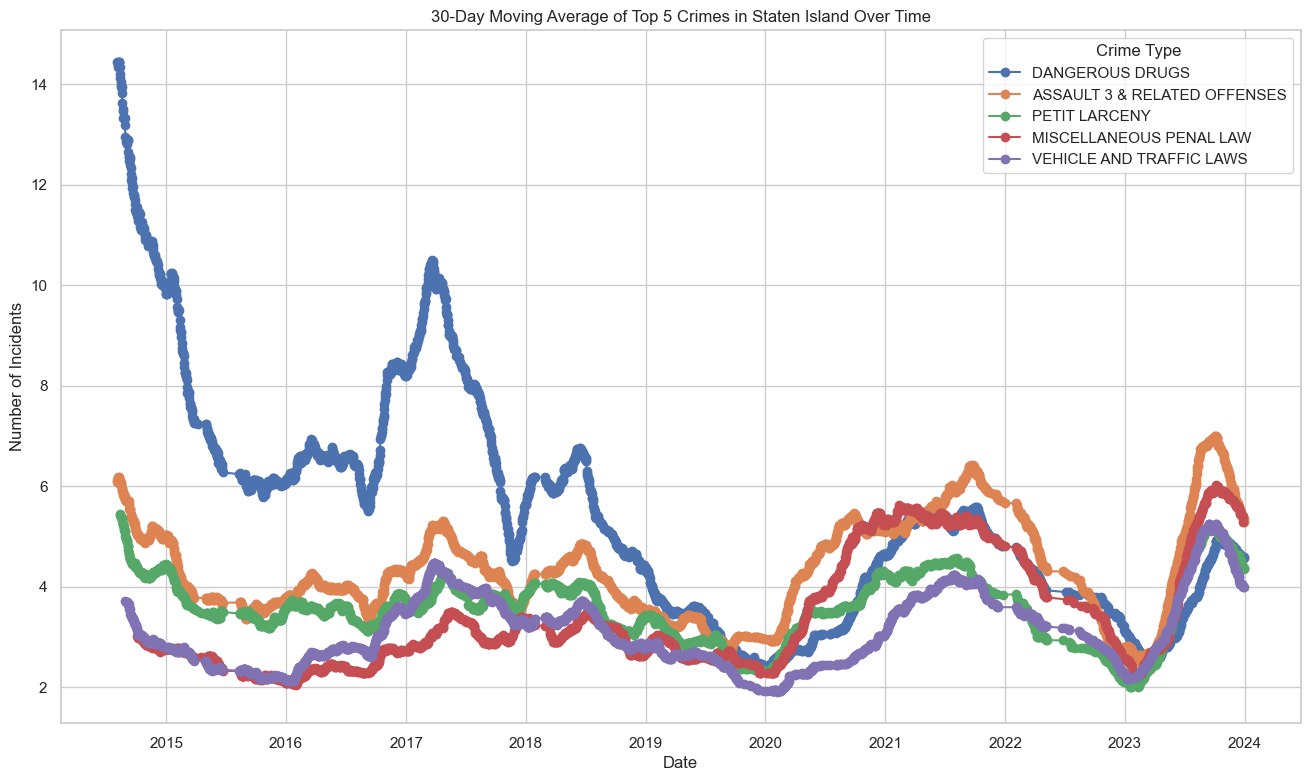

In [87]:
# Identify top 5 crimes for each borough
top_crimes_per_borough = {}

# Define borough keys and labels for reference
borough_labels = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
borough_keys = ['B', 'K', 'M', 'Q', 'S']

# Determine the top 5 crimes for each borough
for boro_key, boro_label in zip(borough_keys, borough_labels):
    # Filter data for the current borough
    borough_data = historical_df[historical_df['Arrest boro'] == boro_key]
    
    # Group by offense description and count occurrences
    top_crimes = borough_data['Offense description'].value_counts().head(5).index.tolist()
    top_crimes_per_borough[boro_label] = top_crimes

# Plotting the data for each borough with the top 5 crimes
for boro_key, boro_label in zip(borough_keys, borough_labels):
    plt.figure(figsize=(16, 9))  # Set the figure size for better visibility
    
    for crime in top_crimes_per_borough[boro_label]:
        # Filter data for the current crime in the specific borough
        crime_borough_data = historical_df[
            (historical_df['Offense description'] == crime) &
            (historical_df['Arrest boro'] == boro_key)
        ]
        
        # Group by date and count occurrences
        date_counts = crime_borough_data.groupby('Arrest date').size()
        
        # Calculate 30-day moving average
        moving_average = date_counts.rolling(window=180).mean()
        
        # Plotting the data with 30-day moving average
        plt.plot(moving_average.index, moving_average.values, marker='o', linestyle='-', label=crime)
    
    plt.title(f'30-Day Moving Average of Top 5 Crimes in {boro_label} Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Incidents')
    plt.legend(title='Crime Type')
    plt.grid(True)  # Adding a grid for better readability
    plt.show()

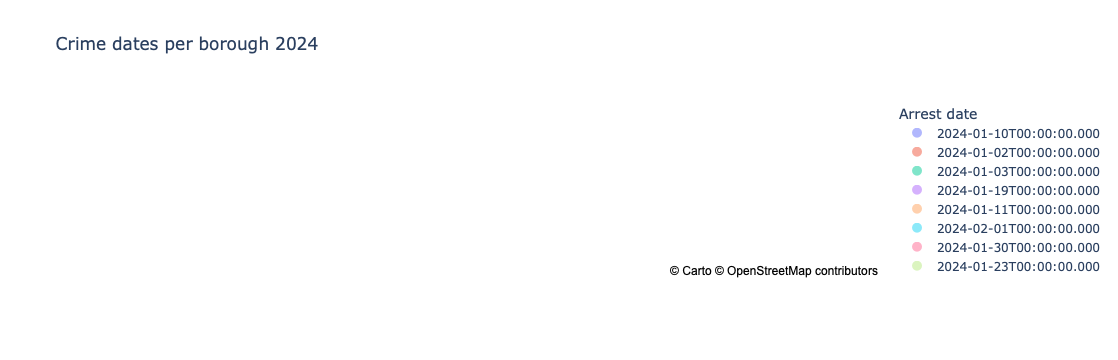

In [36]:
import plotly.express as px
# converint coordinates to numeric
original_df['Latitude'] = pd.to_numeric(original_df['Latitude'], errors='coerce')
original_df['Longitude'] = pd.to_numeric(original_df['Longitude'], errors='coerce')
fig = px.scatter_mapbox(original_df, lat='Latitude', lon='Longitude', color='Arrest date',
                        mapbox_style='carto-positron', zoom=10, opacity=0.5,
                        center={'lat': original_df['Latitude'].mean(), 'lon': original_df['Longitude'].mean()},
                        title='Crime dates per borough 2024')

# Ensure markers are shown
fig.update_traces(mode='markers', marker=dict(size=10))
# Show the figure
fig.show()

In [83]:
fig = px.scatter_mapbox(original_df, lat='Latitude', lon='Longitude', color='Offense description',
                        mapbox_style='carto-positron', zoom=10, opacity=0.5,
                        center={'lat': original_df['Latitude'].mean(), 'lon': original_df['Longitude'].mean()},
                        title='Offenses per borough 2024')

# Ensure markers are shown
fig.update_traces(mode='markers', marker=dict(size=10))
# Show the figure
fig.show()

NameError: name 'px' is not defined

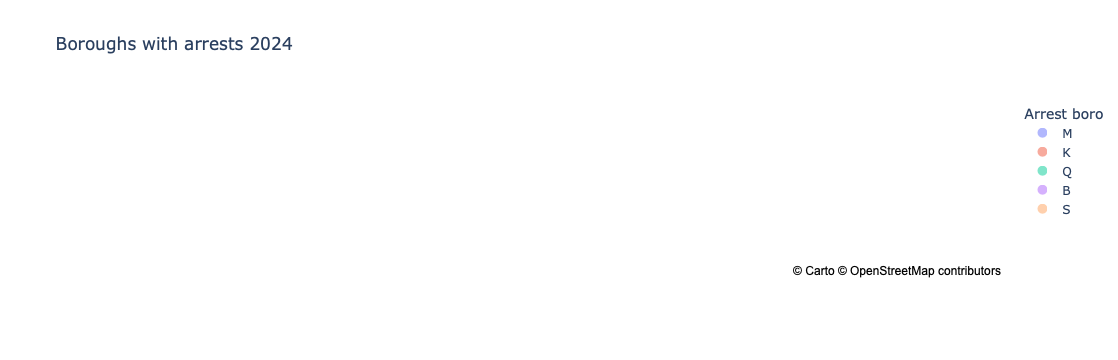

In [38]:
fig = px.scatter_mapbox(original_df, lat='Latitude', lon='Longitude', color='Arrest boro',
                        mapbox_style='carto-positron', zoom=10, opacity=0.5,
                        center={'lat': original_df['Latitude'].mean(), 'lon': original_df['Longitude'].mean()},
                        title='Boroughs with arrests 2024')

# Ensure markers are shown
fig.update_traces(mode='markers', marker=dict(size=10))
# Show the figure
fig.show()

In [39]:
grouped_by_boro_2024=original_df.groupby('Arrest boro')[['Arrest date']].count()
grouped_by_boro_2024

Arrest date
Arrest boro             
B                  11227
K                  13612
M                  12024
Q                  10878
S                   2259

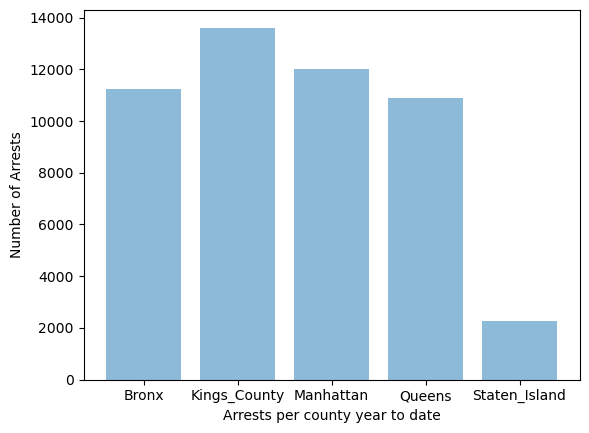

In [26]:
boroughs= ['Bronx','Kings_County', 'Manhattan', 'Queens', 'Staten_Island']
arrest=[11227, 13612, 12024, 10878, 2259]
x_axis = np.arange(len(arrest))
plt.bar(x_axis, arrest, align='center', alpha=0.5)
plt.xticks(x_axis, boroughs)
plt.ylabel('Number of Arrests')
plt.xlabel('Arrests per county year to date')
plt.show()

In [41]:
# Get recods Jan-Apr for 2023
historical_df_sorted = historical_df.sort_values(by='Arrest date')
start_date = '2023-01-01'
end_date = '2023-03-31'
historical_df_filtered = historical_df_sorted.loc[(historical_df_sorted['Arrest date'] >= start_date) & (historical_df_sorted['Arrest date'] <= end_date)]
historical_df_filtered

Empty DataFrame
Columns: [Arrest date, Offense description, Arrest boro, Age group, Sex, Race, Latitude, Longitude, lon_lat, year]
Index: []

In [42]:
historical_df_filtered.tail()

Empty DataFrame
Columns: [Arrest date, Offense description, Arrest boro, Age group, Sex, Race, Latitude, Longitude, lon_lat, year]
Index: []

In [43]:

combined_df = pd.concat([historical_df, original_df])
combined_df

Arrest date                     Offense description  \
0          2014-01-01 00:00:00                                 ROBBERY   
1          2014-01-01 00:00:00                       CRIMINAL TRESPASS   
2          2014-01-01 00:00:00  OFFENSES AGAINST PUBLIC ADMINISTRATION   
3          2014-01-01 00:00:00                          FELONY ASSAULT   
4          2014-01-01 00:00:00            ASSAULT 3 & RELATED OFFENSES   
...                        ...                                     ...   
49995  2024-03-12T00:00:00.000          CRIMINAL MISCHIEF & RELATED OF   
49996  2024-03-20T00:00:00.000                          FELONY ASSAULT   
49997  2024-03-07T00:00:00.000            ASSAULT 3 & RELATED OFFENSES   
49998  2024-03-14T00:00:00.000            ASSAULT 3 & RELATED OFFENSES   
49999  2024-03-13T00:00:00.000                         DANGEROUS DRUGS   

      Arrest boro Age group Sex            Race   Latitude  Longitude  \
0               B       <18   M           BLACK  40.835733 -73.921285   
1               M     25-44   M           BLACK  40.814787 -73.957502   
2               K     25-44   M           BLACK  40.575992 -73.990606   
3               B     25-44   F           WHITE  40.818079 -73.896938   
4               B     25-44   M  WHITE HISPANIC  40.837001 -73.903706   
...           ...       ...  ..             ...        ...        ...   
49995           K       65+   F           BLACK  40.690859 -73.985848   
49996           M     25-44   M  BLACK HISPANIC  40.801908 -73.935612   
49997           M     25-44   M           BLACK  40.803121 -73.952599   
49998           B     25-44   F  WHITE HISPANIC  40.842311 -73.886588   
49999           Q     25-44   M  WHITE HISPANIC  40.687804 -73.833560   

                                                 lon_lat    year  \
0      {'type': 'Point', 'coordinates': [-73.92128542...  2014.0   
1      {'type': 'Point', 'coordinates': [-73.95750196...  2014.0   
2      {'type': 'Point', 'coordinates': [-73.99060607...  2014.0   
3      {'type': 'Point', 'coordinates': [-73.89693760...  2014.0   
4      {'type': 'Point', 'coordinates': [-73.90370600...  2014.0   
...                                                  ...     ...   
49995                                                NaN     NaN   
49996                                                NaN     NaN   
49997                                                NaN     NaN   
49998                                                NaN     NaN   
49999                                                NaN     NaN   

                                         geocoded_column  
0                                                    NaN  
1                                                    NaN  
2                                                    NaN  
3                                                    NaN  
4                                                    NaN  
...                                                  ...  
49995  {'type': 'Point', 'coordinates': [-73.985848, ...  
49996  {'type': 'Point', 'coordinates': [-73.935612, ...  
49997  {'type': 'Point', 'coordinates': [-73.952599, ...  
49998  {'type': 'Point', 'coordinates': [-73.886588, ...  
49999  {'type': 'Point', 'coordinates': [-73.83356012...  

[2552242 rows x 11 columns]

In [44]:
# Combined with only first 3 month of 2023
combined_df_filtered = pd.concat([historical_df_filtered, original_df])
combined_df_filtered

Arrest date             Offense description Arrest boro  \
0      2024-01-10T00:00:00.000                         ROBBERY           M   
1      2024-01-02T00:00:00.000                            RAPE           K   
2      2024-01-03T00:00:00.000    ASSAULT 3 & RELATED OFFENSES           Q   
3      2024-01-19T00:00:00.000                 DANGEROUS DRUGS           B   
4      2024-01-11T00:00:00.000                  FELONY ASSAULT           K   
...                        ...                             ...         ...   
49995  2024-03-12T00:00:00.000  CRIMINAL MISCHIEF & RELATED OF           K   
49996  2024-03-20T00:00:00.000                  FELONY ASSAULT           M   
49997  2024-03-07T00:00:00.000    ASSAULT 3 & RELATED OFFENSES           M   
49998  2024-03-14T00:00:00.000    ASSAULT 3 & RELATED OFFENSES           B   
49999  2024-03-13T00:00:00.000                 DANGEROUS DRUGS           Q   

      Age group Sex            Race   Latitude  Longitude lon_lat  year  \
0           <18   M           BLACK  40.814845 -73.956312     NaN   NaN   
1         25-44   M  WHITE HISPANIC  40.674496 -73.930571     NaN   NaN   
2           65+   F           WHITE  40.662526 -73.846499     NaN   NaN   
3         45-64   M           BLACK  40.855793 -73.843908     NaN   NaN   
4         25-44   F           BLACK  40.694456 -73.934343     NaN   NaN   
...         ...  ..             ...        ...        ...     ...   ...   
49995       65+   F           BLACK  40.690859 -73.985848     NaN   NaN   
49996     25-44   M  BLACK HISPANIC  40.801908 -73.935612     NaN   NaN   
49997     25-44   M           BLACK  40.803121 -73.952599     NaN   NaN   
49998     25-44   F  WHITE HISPANIC  40.842311 -73.886588     NaN   NaN   
49999     25-44   M  WHITE HISPANIC  40.687804 -73.833560     NaN   NaN   

                                         geocoded_column  
0      {'type': 'Point', 'coordinates': [-73.956312, ...  
1      {'type': 'Point', 'coordinates': [-73.93057132...  
2      {'type': 'Point', 'coordinates': [-73.846499, ...  
3      {'type': 'Point', 'coordinates': [-73.843908, ...  
4      {'type': 'Point', 'coordinates': [-73.934343, ...  
...                                                  ...  
49995  {'type': 'Point', 'coordinates': [-73.985848, ...  
49996  {'type': 'Point', 'coordinates': [-73.935612, ...  
49997  {'type': 'Point', 'coordinates': [-73.952599, ...  
49998  {'type': 'Point', 'coordinates': [-73.886588, ...  
49999  {'type': 'Point', 'coordinates': [-73.83356012...  

[50000 rows x 11 columns]

In [45]:
race_counts_2024 = original_df['Race'].value_counts()
race_counts_2023 =historical_df_filtered['Race'].value_counts()
# Sort offenses by counts in descending order
race_counts_2023_sorted = race_counts_2023.sort_values(ascending=False)
race_counts_2024_sorted = race_counts_2024.sort_values(ascending=False)
race_counts_2024_adjusted = race_counts_2024_sorted.head(len(race_counts_2023_sorted))

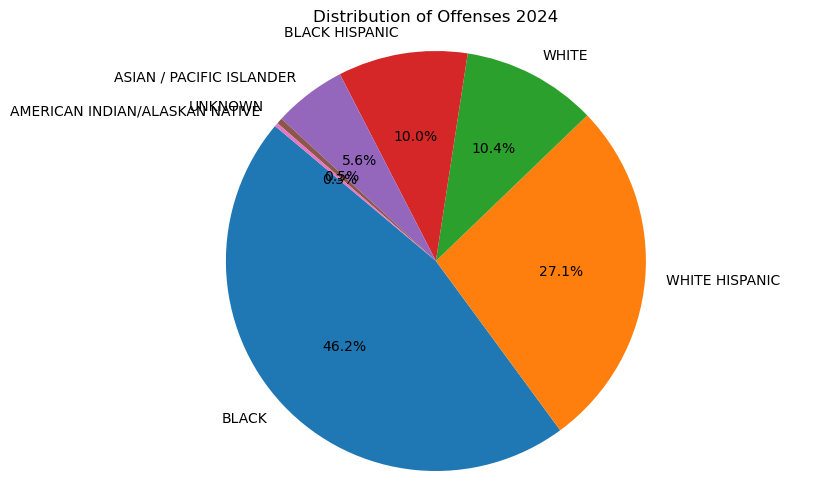

In [46]:
# Show plot fitrst 3 month of 2024 by race
showPieChart(race_counts_2024,"2024")

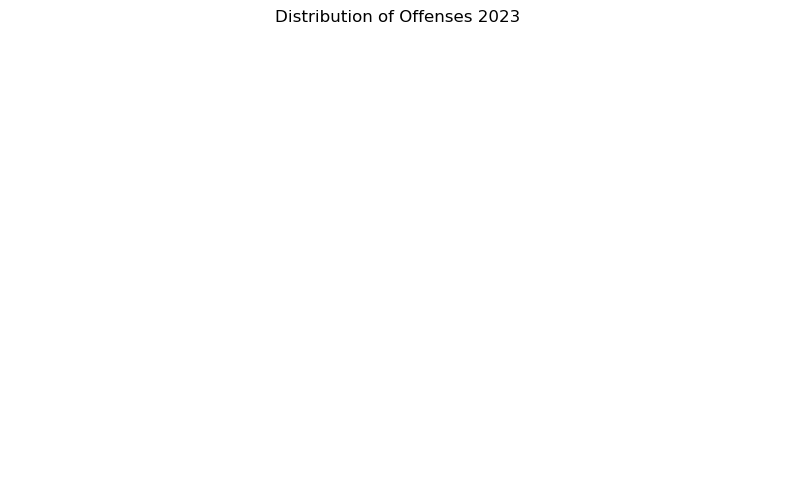

In [47]:
# Show plot fitrst 3 month of 2023 by race
showPieChart(race_counts_2023_sorted,"2023")

In [48]:
age_counts_2024 = original_df['Age group'].value_counts()
age_counts_2023 =historical_df_filtered['Age group'].value_counts()
# Sort offenses by counts in descending order
age_counts_2023_sorted = age_counts_2023.sort_values(ascending=False)
age_counts_2024_sorted = age_counts_2024.sort_values(ascending=False)
age_counts_2024_adjusted = age_counts_2024_sorted.head(len(age_counts_2023_sorted))

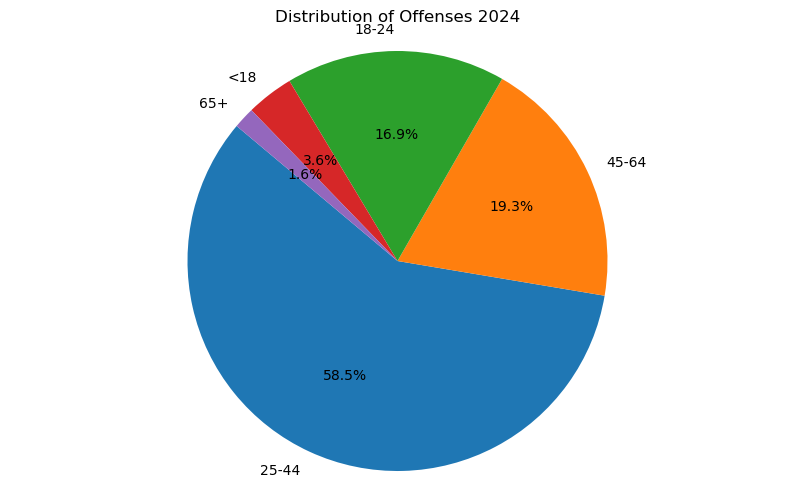

In [49]:
# Show plot fitrst 3 month of 2024 by age
showPieChart(age_counts_2024_sorted,"2024")

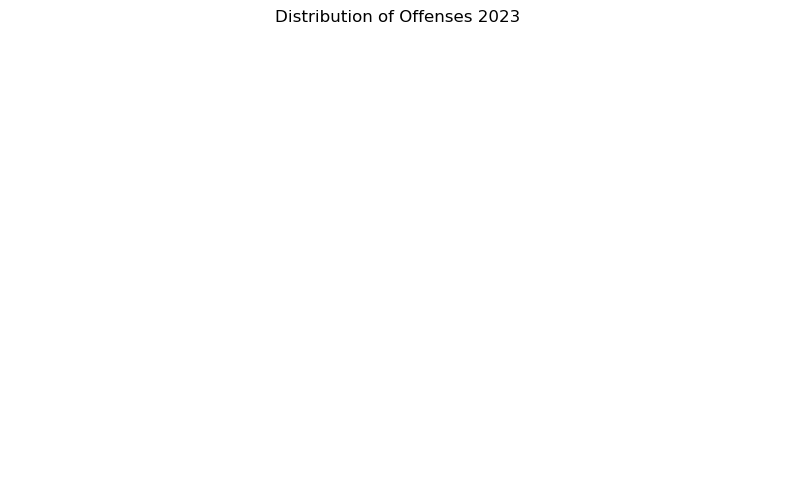

In [50]:
# Show plot fitrst 3 month of 2023 by age
showPieChart(age_counts_2023_sorted,"2023")

In [51]:
c = pd.read_csv("./final_census_df.csv")
c.head()

zip_code  population  poverty_rate  median_income
0       601       17242     62.475351          13092
1       602       38442     51.014515          16358
2       603       48814     49.856599          16603
3       606        6437     64.672984          12832
4       610       27073     43.305138          19309

In [29]:
df_sex_age_borough=original_df.groupby(['Arrest boro' ,'Sex', 'Age group'])[['Arrest date']].count()
df_sex_age_borough

NameError: name 'original_df' is not defined

In [28]:
df_sex_age_borough_reset = df_sex_age_borough.reset_index()
pivot_df = df_sex_age_borough_reset.pivot_table(index=['Arrest boro', 'Age group'], columns='Sex', values='Arrest date')
pivot_df.plot(kind='bar', stacked=True)
plt.xlabel('Borough and Age Group')
plt.ylabel('Number of Arrests Year to Date')
plt.title('Arrests by Sex, Age Group, and Borough')
plt.xticks(rotation=90)
plt.legend(title='Sex')
plt.tight_layout()
plt.show()



NameError: name 'df_sex_age_borough' is not defined